In [1]:
import sys
# sys.path.append("/home/matthias/Documents/EmbeddedAI/deep-microcompression/")
sys.path.append("../../")

from development import (
    Sequential,
    BatchNorm2d,
    Conv2d,
    Linear,
    ReLU,
    MaxPool2d,
    Flatten, 

    EarlyStopper,
    Estimator,
    
    QuantizationGranularity,
    QuantizationScheme
)

/home/matthias/Documents/EmbeddedAI/deep-microcompression/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import copy, itertools

import torch
from torch import nn, optim
from torch.utils import data
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
lenet5_file = f"lenet5_state_dict_25.pth"
log_compression_details_file = "lenet5_compression_log.csv"

hp_deployment_base_dir = "./HP HP Pavilion Laptop 15-cs3xxx/"
hp_src_dir = os.path.join(hp_deployment_base_dir, "src")
hp_include_dir = os.path.join(hp_deployment_base_dir, "include")

arduino_deployment_base_dir = "./Arduino Nano 33 BLE/"
arduino_src_dir = os.path.join(arduino_deployment_base_dir, "src")
arduino_include_dir = os.path.join(arduino_deployment_base_dir, "include")

arduino_uno_deployment_base_dir = "./Arduino Uno/"
arduino_uno_src_dir = os.path.join(arduino_uno_deployment_base_dir, "src")
arduino_uno_include_dir = os.path.join(arduino_uno_deployment_base_dir, "include")

NAS_PARAMS_FILE = "nas_parameters.pickle"
INPUT_SHAPE = (1, 28, 28)

DEVICE

'cuda'

In [4]:
LUCKY_NUMBER = 25

# Torch seeds
torch.manual_seed(LUCKY_NUMBER)
torch.cuda.manual_seed(LUCKY_NUMBER)

# cuDNN determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optional: for full reproducibility (at the cost of speed)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.use_deterministic_algorithms(True)

In [5]:
INPUT_SHAPE = (1, 28, 28)

data_transform = transforms.Compose([
    transforms.RandomCrop((24, 24)),
    transforms.Resize(INPUT_SHAPE[1:]),
    transforms.ToTensor(),
])

mnist_train_dataset = datasets.MNIST("../../../Datasets/", train=True, download=True, transform=data_transform)
mnist_test_dataset = datasets.MNIST("../../../Datasets/", train=False, download=True, transform=data_transform)

mnist_train_loader = data.DataLoader(mnist_train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count(), drop_last=False)
mnist_test_loader = data.DataLoader(mnist_test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count(), drop_last=False)

In [6]:
lenet5_model = Sequential(
    Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, pad=tuple([2]*4), bias=True),
    BatchNorm2d(num_features=6),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2, padding=0),

    Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True),
    BatchNorm2d(num_features=16),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2, padding=0),

    Flatten(),
    
    Linear(in_features=16*5*5, out_features=84, bias=True),
    ReLU(),
    Linear(in_features=84, out_features=10, bias=True),
).to(DEVICE)

accuracy_fun = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).to(torch.float).mean().item()*100

In [ ]:
try:
    raise(RuntimeError)
    # lenet5_model.cpu()
    # lenet5_model.load_state_dict(torch.load(lenet5_file, weights_only=True), strict=True)
    # lenet5_model.to(DEVICE)

except (RuntimeError, FileNotFoundError) as e:
    early_stopper = EarlyStopper(
        monitor_metric="validation_loss",
        delta=1e-7,
        mode="min",
        patience=4,
        restore_best_state_dict=True,
    )

    criterion_fun = nn.CrossEntropyLoss()
    optimizion_fun = optim.Adam(lenet5_model.parameters(), lr=1.e-3)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=2)

    lenet5_model.fit(
        mnist_train_loader, 20, 
        criterion_fun, optimizion_fun,
        # lr_scheduler,
        validation_dataloader=mnist_test_loader, 
        metrics={"acc" : accuracy_fun},
        # callbacks=[early_stopper],
        device=DEVICE
    )
    lenet5_model.cpu()
    torch.save(lenet5_model.state_dict(), lenet5_file)
    lenet5_model.to(DEVICE)

print(f"The accuracy of the base model has an accuracy of {lenet5_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, device=DEVICE)["acc"]}")


DMC Training (Epochs 1-20):   0%|          | 0/20 [00:06<?, ?it/s]


KeyboardInterrupt: 

## NAS for Channel Pruning
We generated 1000 samples, which is about 2.5% of the total possible hyperparameter. 6*16*400

In [ ]:
nas_parameters = []
if os.path.exists(NAS_PARAMS_FILE):
    nas_parameters = torch.load(NAS_PARAMS_FILE)
    assert len(nas_parameters) == 1000, "params in nas file is not 1000"

else:
    nas_parameters = lenet5_model.get_nas_prune_channel(
        INPUT_SHAPE, mnist_test_loader, accuracy_fun, DEVICE, 
        num_data=1000, train=True, train_dataloader=mnist_train_loader, epochs=2, 
        criterion_fun= nn.CrossEntropyLoss(), random_seed=LUCKY_NUMBER
    )
    torch.save(nas_parameters, NAS_PARAMS_FILE)

In [ ]:
nas_parameters

[[4, 1, 54, 96.94],
 [3, 0, 26, 98.5],
 [3, 15, 35, 82.73],
 [5, 5, 4, 96.39],
 [4, 15, 41, 80.48],
 [0, 7, 46, 98.42],
 [0, 13, 17, 96.39],
 [4, 11, 48, 94.89],
 [3, 9, 33, 96.59],
 [3, 5, 38, 98.22],
 [5, 11, 17, 94.21],
 [3, 7, 56, 97.08],
 [4, 12, 5, 94.01],
 [4, 0, 30, 97.3],
 [1, 6, 38, 98.42],
 [4, 11, 30, 94.92],
 [2, 14, 55, 92.66],
 [3, 2, 83, 31.0],
 [4, 10, 64, 94.58],
 [1, 7, 52, 97.93],
 [1, 1, 4, 99.13],
 [3, 9, 77, 92.86],
 [5, 2, 68, 94.51],
 [0, 4, 49, 98.79],
 [4, 11, 76, 90.73],
 [1, 3, 12, 98.85],
 [3, 5, 24, 97.97],
 [2, 13, 53, 95.04],
 [3, 7, 35, 97.54],
 [1, 5, 15, 98.89],
 [2, 14, 38, 92.58],
 [1, 5, 22, 98.69],
 [3, 11, 41, 95.81],
 [3, 7, 0, 97.7],
 [4, 1, 42, 97.33],
 [2, 7, 10, 98.09],
 [2, 14, 51, 91.66],
 [4, 5, 49, 96.88],
 [3, 7, 67, 96.37],
 [2, 15, 77, 77.54],
 [3, 2, 21, 98.18],
 [3, 14, 51, 91.04],
 [1, 13, 69, 94.28],
 [4, 11, 68, 93.45],
 [3, 15, 21, 81.22],
 [4, 14, 12, 90.28],
 [3, 1, 0, 98.34],
 [3, 2, 6, 98.38],
 [2, 2, 19, 98.73],
 [0, 14, 6

## Channel Prunner Estiamtor

In [ ]:
estimator = Estimator(nas_parameters, device=DEVICE, hidden_dim=[128, 128, 128], dropout=.75)
estimator_history = estimator.fit(epochs=400)

DMC Training (Epochs 1-400):   0%|          | 1/400 [00:00<01:41,  3.91it/s]

epoch    0 | train loss 8739.7454 | validation loss 8713.2051 | train mse 8739.7454 | validation mse 8713.2062 | train rmse 93.4837 | validation rmse 93.3406 | train abs 93.0968 | validation abs 92.4165


epoch    1 | train loss 8620.9701 | validation loss 8630.8506 | train mse 8620.9701 | validation mse 8630.8506 | train rmse 92.8446 | validation rmse 92.8985 | train abs 92.4460 | validation abs 91.9733


DMC Training (Epochs 1-400):   1%|          | 3/400 [00:00<00:43,  9.17it/s]

epoch    2 | train loss 8485.0055 | validation loss 8559.5176 | train mse 8485.0055 | validation mse 8559.5186 | train rmse 92.1118 | validation rmse 92.5139 | train abs 91.7132 | validation abs 91.5898


epoch    3 | train loss 8366.2561 | validation loss 8475.6133 | train mse 8366.2561 | validation mse 8475.6130 | train rmse 91.4644 | validation rmse 92.0594 | train abs 91.0611 | validation abs 91.1368


DMC Training (Epochs 1-400):   1%|▏         | 5/400 [00:00<00:32, 12.33it/s]

epoch    4 | train loss 8218.8237 | validation loss 8383.0166 | train mse 8218.8237 | validation mse 8383.0167 | train rmse 90.6559 | validation rmse 91.5552 | train abs 90.2369 | validation abs 90.6356


epoch    5 | train loss 8078.6765 | validation loss 8292.9902 | train mse 8078.6765 | validation mse 8292.9905 | train rmse 89.8769 | validation rmse 91.0624 | train abs 89.4532 | validation abs 90.1465


DMC Training (Epochs 1-400):   2%|▏         | 7/400 [00:00<00:27, 14.47it/s]

epoch    6 | train loss 7921.8112 | validation loss 8170.1099 | train mse 7921.8112 | validation mse 8170.1098 | train rmse 89.0011 | validation rmse 90.3854 | train abs 88.5701 | validation abs 89.4736


epoch    7 | train loss 7744.1497 | validation loss 8014.1792 | train mse 7744.1497 | validation mse 8014.1794 | train rmse 87.9953 | validation rmse 89.5188 | train abs 87.5587 | validation abs 88.6091


DMC Training (Epochs 1-400):   2%|▏         | 9/400 [00:00<00:24, 16.01it/s]

epoch    8 | train loss 7570.0457 | validation loss 7879.3672 | train mse 7570.0457 | validation mse 7879.3670 | train rmse 87.0021 | validation rmse 88.7629 | train abs 86.5540 | validation abs 87.8567


epoch    9 | train loss 7387.2933 | validation loss 7697.8394 | train mse 7387.2933 | validation mse 7697.8398 | train rmse 85.9445 | validation rmse 87.7346 | train abs 85.4892 | validation abs 86.8337


epoch   10 | train loss 7226.6311 | validation loss 7499.5527 | train mse 7226.6311 | validation mse 7499.5527 | train rmse 85.0044 | validation rmse 86.5974 | train abs 84.5475 | validation abs 85.6996


DMC Training (Epochs 1-400):   3%|▎         | 12/400 [00:00<00:21, 17.64it/s]

epoch   11 | train loss 7001.8392 | validation loss 7270.5879 | train mse 7001.8392 | validation mse 7270.5879 | train rmse 83.6697 | validation rmse 85.2655 | train abs 83.1882 | validation abs 84.3702


epoch   12 | train loss 6780.5150 | validation loss 7059.0356 | train mse 6780.5150 | validation mse 7059.0358 | train rmse 82.3370 | validation rmse 84.0161 | train abs 81.8286 | validation abs 83.1253


DMC Training (Epochs 1-400):   4%|▎         | 14/400 [00:00<00:21, 18.23it/s]

epoch   13 | train loss 6585.2243 | validation loss 6840.1743 | train mse 6585.2243 | validation mse 6840.1744 | train rmse 81.1393 | validation rmse 82.7036 | train abs 80.6409 | validation abs 81.8197


epoch   14 | train loss 6394.1940 | validation loss 6563.0996 | train mse 6394.1940 | validation mse 6563.1001 | train rmse 79.9521 | validation rmse 81.0115 | train abs 79.4241 | validation abs 80.1322


epoch   15 | train loss 6098.0749 | validation loss 6292.3882 | train mse 6098.0749 | validation mse 6292.3882 | train rmse 78.0842 | validation rmse 79.3232 | train abs 77.5191 | validation abs 78.4496


DMC Training (Epochs 1-400):   4%|▍         | 17/400 [00:01<00:20, 18.96it/s]

epoch   16 | train loss 5892.4475 | validation loss 6024.0947 | train mse 5892.4475 | validation mse 6024.0948 | train rmse 76.7524 | validation rmse 77.6138 | train abs 76.1645 | validation abs 76.7387


epoch   17 | train loss 5672.6696 | validation loss 5748.1562 | train mse 5672.6696 | validation mse 5748.1564 | train rmse 75.3080 | validation rmse 75.8153 | train abs 74.6299 | validation abs 74.9406


epoch   18 | train loss 5348.2982 | validation loss 5466.0312 | train mse 5348.2982 | validation mse 5466.0313 | train rmse 73.1226 | validation rmse 73.9312 | train abs 72.4503 | validation abs 73.0523


DMC Training (Epochs 1-400):   5%|▌         | 20/400 [00:01<00:19, 19.63it/s]

epoch   19 | train loss 5148.2425 | validation loss 5165.2642 | train mse 5148.2425 | validation mse 5165.2644 | train rmse 71.7427 | validation rmse 71.8680 | train abs 71.0987 | validation abs 70.9762


epoch   20 | train loss 4874.4535 | validation loss 4875.3506 | train mse 4874.4535 | validation mse 4875.3507 | train rmse 69.8099 | validation rmse 69.8211 | train abs 69.1201 | validation abs 68.9080


epoch   21 | train loss 4658.9269 | validation loss 4562.3633 | train mse 4658.9269 | validation mse 4562.3634 | train rmse 68.2485 | validation rmse 67.5420 | train abs 67.4717 | validation abs 66.5993


DMC Training (Epochs 1-400):   6%|▌         | 23/400 [00:01<00:18, 20.13it/s]

epoch   22 | train loss 4356.9464 | validation loss 4324.4995 | train mse 4356.9464 | validation mse 4324.4995 | train rmse 65.9941 | validation rmse 65.7570 | train abs 65.0544 | validation abs 64.7927


epoch   23 | train loss 4167.2807 | validation loss 4087.0242 | train mse 4167.2807 | validation mse 4087.0242 | train rmse 64.5416 | validation rmse 63.9245 | train abs 63.5512 | validation abs 62.9161


epoch   24 | train loss 3960.3037 | validation loss 3805.8286 | train mse 3960.3037 | validation mse 3805.8286 | train rmse 62.9163 | validation rmse 61.6850 | train abs 61.8236 | validation abs 60.6557


DMC Training (Epochs 1-400):   6%|▋         | 26/400 [00:01<00:18, 20.35it/s]

epoch   25 | train loss 3638.1360 | validation loss 3553.8130 | train mse 3638.1360 | validation mse 3553.8134 | train rmse 60.3040 | validation rmse 59.6056 | train abs 59.1187 | validation abs 58.5352


epoch   26 | train loss 3435.2444 | validation loss 3291.6663 | train mse 3435.2444 | validation mse 3291.6662 | train rmse 58.5980 | validation rmse 57.3648 | train abs 57.2010 | validation abs 56.2801


epoch   27 | train loss 3136.6926 | validation loss 2930.4106 | train mse 3136.6926 | validation mse 2930.4109 | train rmse 55.9871 | validation rmse 54.1240 | train abs 54.4682 | validation abs 53.0131


DMC Training (Epochs 1-400):   7%|▋         | 29/400 [00:01<00:18, 20.08it/s]

epoch   28 | train loss 3001.6920 | validation loss 2766.4634 | train mse 3001.6920 | validation mse 2766.4635 | train rmse 54.7768 | validation rmse 52.5870 | train abs 53.2722 | validation abs 51.4370


epoch   29 | train loss 2858.8774 | validation loss 2506.4548 | train mse 2858.8774 | validation mse 2506.4549 | train rmse 53.4327 | validation rmse 50.0534 | train abs 51.6629 | validation abs 48.8808


epoch   30 | train loss 2589.2750 | validation loss 2455.3081 | train mse 2589.2750 | validation mse 2455.3083 | train rmse 50.8735 | validation rmse 49.5369 | train abs 49.3246 | validation abs 48.2996


DMC Training (Epochs 1-400):   8%|▊         | 32/400 [00:01<00:18, 19.91it/s]

epoch   31 | train loss 2440.4240 | validation loss 2207.2734 | train mse 2440.4240 | validation mse 2207.2736 | train rmse 49.3810 | validation rmse 46.9639 | train abs 47.5409 | validation abs 45.6650


epoch   32 | train loss 2227.2719 | validation loss 1975.3857 | train mse 2227.2719 | validation mse 1975.3858 | train rmse 47.1611 | validation rmse 44.4256 | train abs 45.0529 | validation abs 43.1417


DMC Training (Epochs 1-400):   8%|▊         | 34/400 [00:01<00:18, 19.80it/s]

epoch   33 | train loss 2035.8719 | validation loss 1824.4534 | train mse 2035.8719 | validation mse 1824.4535 | train rmse 45.0967 | validation rmse 42.6914 | train abs 42.7430 | validation abs 41.4183


epoch   34 | train loss 1887.8070 | validation loss 1620.6202 | train mse 1887.8070 | validation mse 1620.6202 | train rmse 43.4326 | validation rmse 40.2380 | train abs 41.0400 | validation abs 39.0913


DMC Training (Epochs 1-400):   9%|▉         | 36/400 [00:02<00:18, 19.81it/s]

epoch   35 | train loss 1787.5842 | validation loss 1531.5898 | train mse 1787.5842 | validation mse 1531.5898 | train rmse 42.2422 | validation rmse 39.1148 | train abs 39.6968 | validation abs 37.9606


epoch   36 | train loss 1493.8762 | validation loss 1391.5999 | train mse 1493.8762 | validation mse 1391.5998 | train rmse 38.5803 | validation rmse 37.2832 | train abs 35.6224 | validation abs 36.1219


epoch   37 | train loss 1428.6772 | validation loss 1272.1978 | train mse 1428.6772 | validation mse 1272.1978 | train rmse 37.7741 | validation rmse 35.6452 | train abs 34.6717 | validation abs 34.4290


DMC Training (Epochs 1-400):  10%|▉         | 39/400 [00:02<00:18, 19.88it/s]

epoch   38 | train loss 1354.7131 | validation loss 1142.9160 | train mse 1354.7131 | validation mse 1142.9161 | train rmse 36.7598 | validation rmse 33.7848 | train abs 33.4013 | validation abs 32.5907


epoch   39 | train loss 1292.4546 | validation loss 1025.7106 | train mse 1292.4546 | validation mse 1025.7106 | train rmse 35.8905 | validation rmse 32.0046 | train abs 32.5234 | validation abs 30.8912


epoch   40 | train loss 1133.4662 | validation loss 943.7247 | train mse 1133.4662 | validation mse 943.7246 | train rmse 33.6349 | validation rmse 30.6943 | train abs 29.8987 | validation abs 29.5081


DMC Training (Epochs 1-400):  10%|█         | 42/400 [00:02<00:17, 19.94it/s]

epoch   41 | train loss 1041.3627 | validation loss 842.2170 | train mse 1041.3627 | validation mse 842.2171 | train rmse 32.2278 | validation rmse 28.9950 | train abs 28.4705 | validation abs 27.8668


epoch   42 | train loss 993.6265 | validation loss 764.7512 | train mse 993.6265 | validation mse 764.7513 | train rmse 31.4911 | validation rmse 27.6275 | train abs 27.5500 | validation abs 26.3714


epoch   43 | train loss 871.2735 | validation loss 757.9197 | train mse 871.2735 | validation mse 757.9198 | train rmse 29.4408 | validation rmse 27.5012 | train abs 25.8638 | validation abs 26.1340


DMC Training (Epochs 1-400):  11%|█▏        | 45/400 [00:02<00:17, 19.78it/s]

epoch   44 | train loss 805.6821 | validation loss 679.7046 | train mse 805.6821 | validation mse 679.7046 | train rmse 28.3538 | validation rmse 26.0432 | train abs 24.4013 | validation abs 24.6803


epoch   45 | train loss 791.8385 | validation loss 681.0039 | train mse 791.8385 | validation mse 681.0039 | train rmse 28.0656 | validation rmse 26.0703 | train abs 24.0164 | validation abs 24.7402


DMC Training (Epochs 1-400):  12%|█▏        | 47/400 [00:02<00:17, 19.79it/s]

epoch   46 | train loss 806.8707 | validation loss 609.2436 | train mse 806.8707 | validation mse 609.2436 | train rmse 28.3600 | validation rmse 24.6533 | train abs 24.3079 | validation abs 23.2298


epoch   47 | train loss 703.3293 | validation loss 553.3000 | train mse 703.3293 | validation mse 553.3000 | train rmse 26.4848 | validation rmse 23.4838 | train abs 22.3536 | validation abs 21.5929


DMC Training (Epochs 1-400):  12%|█▏        | 49/400 [00:02<00:17, 19.64it/s]

epoch   48 | train loss 696.0535 | validation loss 530.1844 | train mse 696.0535 | validation mse 530.1843 | train rmse 26.2954 | validation rmse 22.9884 | train abs 21.7797 | validation abs 21.1333


epoch   49 | train loss 651.7927 | validation loss 497.7617 | train mse 651.7927 | validation mse 497.7617 | train rmse 25.4490 | validation rmse 22.2736 | train abs 20.9310 | validation abs 20.3933


DMC Training (Epochs 1-400):  13%|█▎        | 51/400 [00:02<00:17, 19.57it/s]

epoch   50 | train loss 647.9636 | validation loss 443.3055 | train mse 647.9636 | validation mse 443.3056 | train rmse 25.4064 | validation rmse 21.0170 | train abs 21.1228 | validation abs 19.1933


epoch   51 | train loss 597.1476 | validation loss 415.5784 | train mse 597.1476 | validation mse 415.5784 | train rmse 24.3480 | validation rmse 20.3489 | train abs 20.2251 | validation abs 18.5895


DMC Training (Epochs 1-400):  13%|█▎        | 53/400 [00:02<00:17, 19.54it/s]

epoch   52 | train loss 563.6285 | validation loss 379.3632 | train mse 563.6285 | validation mse 379.3632 | train rmse 23.6940 | validation rmse 19.4376 | train abs 19.5389 | validation abs 17.5997


epoch   53 | train loss 552.5686 | validation loss 396.9165 | train mse 552.5686 | validation mse 396.9165 | train rmse 23.4147 | validation rmse 19.8779 | train abs 19.2546 | validation abs 18.0659


DMC Training (Epochs 1-400):  14%|█▍        | 55/400 [00:02<00:17, 19.55it/s]

epoch   54 | train loss 547.9498 | validation loss 369.7020 | train mse 547.9498 | validation mse 369.7020 | train rmse 23.2922 | validation rmse 19.1806 | train abs 18.9304 | validation abs 17.2409


epoch   55 | train loss 516.5029 | validation loss 366.5677 | train mse 516.5029 | validation mse 366.5677 | train rmse 22.6552 | validation rmse 19.0968 | train abs 18.5026 | validation abs 16.9421


DMC Training (Epochs 1-400):  14%|█▍        | 57/400 [00:03<00:17, 19.60it/s]

epoch   56 | train loss 583.6871 | validation loss 336.5694 | train mse 583.6871 | validation mse 336.5694 | train rmse 24.0586 | validation rmse 18.2978 | train abs 19.4267 | validation abs 16.1352


epoch   57 | train loss 540.1654 | validation loss 343.9524 | train mse 540.1654 | validation mse 343.9524 | train rmse 23.1688 | validation rmse 18.4929 | train abs 18.7758 | validation abs 16.0436


DMC Training (Epochs 1-400):  15%|█▍        | 59/400 [00:03<00:17, 19.67it/s]

epoch   58 | train loss 521.7364 | validation loss 340.9894 | train mse 521.7364 | validation mse 340.9894 | train rmse 22.7180 | validation rmse 18.4122 | train abs 18.3672 | validation abs 15.9050


epoch   59 | train loss 478.3926 | validation loss 308.0562 | train mse 478.3926 | validation mse 308.0563 | train rmse 21.7821 | validation rmse 17.4943 | train abs 17.6830 | validation abs 14.8612


DMC Training (Epochs 1-400):  15%|█▌        | 61/400 [00:03<00:17, 19.69it/s]

epoch   60 | train loss 504.3019 | validation loss 287.9228 | train mse 504.3019 | validation mse 287.9228 | train rmse 22.3823 | validation rmse 16.9147 | train abs 18.0974 | validation abs 14.5084


epoch   61 | train loss 506.8621 | validation loss 310.5659 | train mse 506.8621 | validation mse 310.5659 | train rmse 22.4394 | validation rmse 17.5674 | train abs 18.3525 | validation abs 15.1551


DMC Training (Epochs 1-400):  16%|█▌        | 63/400 [00:03<00:17, 19.68it/s]

epoch   62 | train loss 485.7433 | validation loss 295.0903 | train mse 485.7433 | validation mse 295.0903 | train rmse 21.9588 | validation rmse 17.1240 | train abs 17.5054 | validation abs 14.5534


epoch   63 | train loss 506.1422 | validation loss 271.5034 | train mse 506.1422 | validation mse 271.5033 | train rmse 22.4055 | validation rmse 16.4186 | train abs 18.0537 | validation abs 13.6673


DMC Training (Epochs 1-400):  16%|█▋        | 65/400 [00:03<00:17, 19.70it/s]

epoch   64 | train loss 567.4114 | validation loss 292.1560 | train mse 567.4114 | validation mse 292.1560 | train rmse 23.6478 | validation rmse 17.0357 | train abs 18.9167 | validation abs 14.4049


epoch   65 | train loss 453.6683 | validation loss 266.0361 | train mse 453.6683 | validation mse 266.0361 | train rmse 21.1931 | validation rmse 16.2504 | train abs 17.2066 | validation abs 13.5944


DMC Training (Epochs 1-400):  17%|█▋        | 67/400 [00:03<00:16, 19.61it/s]

epoch   66 | train loss 499.4370 | validation loss 251.6120 | train mse 499.4370 | validation mse 251.6119 | train rmse 22.2572 | validation rmse 15.8027 | train abs 18.0741 | validation abs 13.4049


epoch   67 | train loss 530.0796 | validation loss 249.9649 | train mse 530.0796 | validation mse 249.9649 | train rmse 22.9146 | validation rmse 15.7530 | train abs 18.3662 | validation abs 13.4976


epoch   68 | train loss 443.5608 | validation loss 243.6483 | train mse 443.5608 | validation mse 243.6483 | train rmse 20.9393 | validation rmse 15.5562 | train abs 16.8961 | validation abs 13.4737


DMC Training (Epochs 1-400):  18%|█▊        | 70/400 [00:03<00:16, 19.92it/s]

epoch   69 | train loss 461.0523 | validation loss 251.5025 | train mse 461.0523 | validation mse 251.5025 | train rmse 21.3459 | validation rmse 15.8080 | train abs 16.7155 | validation abs 13.5191


epoch   70 | train loss 516.8176 | validation loss 235.8688 | train mse 516.8176 | validation mse 235.8688 | train rmse 22.6436 | validation rmse 15.3067 | train abs 18.0971 | validation abs 13.0323


epoch   71 | train loss 475.1519 | validation loss 263.6262 | train mse 475.1519 | validation mse 263.6262 | train rmse 21.7489 | validation rmse 16.1871 | train abs 17.4318 | validation abs 14.0116


DMC Training (Epochs 1-400):  18%|█▊        | 73/400 [00:03<00:16, 19.89it/s]

epoch   72 | train loss 486.9802 | validation loss 260.5319 | train mse 486.9802 | validation mse 260.5319 | train rmse 21.9855 | validation rmse 16.0868 | train abs 17.5998 | validation abs 13.6881


epoch   73 | train loss 495.4319 | validation loss 247.1792 | train mse 495.4319 | validation mse 247.1792 | train rmse 22.1063 | validation rmse 15.6549 | train abs 17.5660 | validation abs 12.9093


DMC Training (Epochs 1-400):  19%|█▉        | 75/400 [00:04<00:16, 19.75it/s]

epoch   74 | train loss 504.2630 | validation loss 230.9874 | train mse 504.2630 | validation mse 230.9874 | train rmse 22.3753 | validation rmse 15.1297 | train abs 17.9025 | validation abs 12.3023


epoch   75 | train loss 520.7496 | validation loss 254.0557 | train mse 520.7496 | validation mse 254.0557 | train rmse 22.7227 | validation rmse 15.8707 | train abs 17.8724 | validation abs 13.1791


epoch   76 | train loss 521.2825 | validation loss 288.6777 | train mse 521.2825 | validation mse 288.6777 | train rmse 22.7317 | validation rmse 16.9247 | train abs 18.1854 | validation abs 14.3083


DMC Training (Epochs 1-400):  20%|█▉        | 78/400 [00:04<00:16, 19.84it/s]

epoch   77 | train loss 488.5158 | validation loss 272.2716 | train mse 488.5158 | validation mse 272.2716 | train rmse 21.9999 | validation rmse 16.4356 | train abs 17.7382 | validation abs 13.8195


epoch   78 | train loss 500.4802 | validation loss 275.0172 | train mse 500.4802 | validation mse 275.0172 | train rmse 22.2900 | validation rmse 16.5157 | train abs 17.6166 | validation abs 13.8236


DMC Training (Epochs 1-400):  20%|██        | 80/400 [00:04<00:16, 19.80it/s]

epoch   79 | train loss 483.2306 | validation loss 250.4006 | train mse 483.2306 | validation mse 250.4006 | train rmse 21.9419 | validation rmse 15.7535 | train abs 17.3365 | validation abs 12.8001


epoch   80 | train loss 504.6162 | validation loss 260.8812 | train mse 504.6162 | validation mse 260.8812 | train rmse 22.3397 | validation rmse 16.0787 | train abs 17.8047 | validation abs 12.8649


DMC Training (Epochs 1-400):  20%|██        | 82/400 [00:04<00:16, 19.73it/s]

epoch   81 | train loss 501.5743 | validation loss 236.8770 | train mse 501.5743 | validation mse 236.8770 | train rmse 22.3051 | validation rmse 15.3239 | train abs 17.3724 | validation abs 12.2050


epoch   82 | train loss 503.9859 | validation loss 218.7282 | train mse 503.9859 | validation mse 218.7282 | train rmse 22.3406 | validation rmse 14.7277 | train abs 17.7930 | validation abs 11.7538


DMC Training (Epochs 1-400):  21%|██        | 84/400 [00:04<00:16, 19.73it/s]

epoch   83 | train loss 469.8804 | validation loss 226.8035 | train mse 469.8804 | validation mse 226.8035 | train rmse 21.5969 | validation rmse 15.0113 | train abs 17.2187 | validation abs 12.2352


epoch   84 | train loss 522.4799 | validation loss 226.4105 | train mse 522.4799 | validation mse 226.4106 | train rmse 22.7476 | validation rmse 15.0022 | train abs 18.0503 | validation abs 12.2714


DMC Training (Epochs 1-400):  22%|██▏       | 86/400 [00:04<00:15, 19.73it/s]

epoch   85 | train loss 491.2832 | validation loss 219.9203 | train mse 491.2832 | validation mse 219.9204 | train rmse 22.0637 | validation rmse 14.7817 | train abs 17.5738 | validation abs 11.8289


epoch   86 | train loss 528.9506 | validation loss 224.8099 | train mse 528.9506 | validation mse 224.8099 | train rmse 22.8955 | validation rmse 14.9459 | train abs 18.3131 | validation abs 11.9584


DMC Training (Epochs 1-400):  22%|██▏       | 88/400 [00:04<00:15, 19.53it/s]

epoch   87 | train loss 461.6274 | validation loss 214.8311 | train mse 461.6274 | validation mse 214.8311 | train rmse 21.4044 | validation rmse 14.6056 | train abs 16.9364 | validation abs 11.7432


epoch   88 | train loss 528.9225 | validation loss 248.9411 | train mse 528.9225 | validation mse 248.9411 | train rmse 22.8393 | validation rmse 15.7254 | train abs 18.0875 | validation abs 13.1578


DMC Training (Epochs 1-400):  22%|██▎       | 90/400 [00:04<00:15, 19.50it/s]

epoch   89 | train loss 471.6966 | validation loss 246.4583 | train mse 471.6966 | validation mse 246.4583 | train rmse 21.6454 | validation rmse 15.6350 | train abs 17.3982 | validation abs 12.6970


epoch   90 | train loss 464.3619 | validation loss 249.4635 | train mse 464.3619 | validation mse 249.4635 | train rmse 21.3574 | validation rmse 15.7314 | train abs 17.2987 | validation abs 12.7115


DMC Training (Epochs 1-400):  23%|██▎       | 92/400 [00:04<00:15, 19.53it/s]

epoch   91 | train loss 480.2247 | validation loss 253.4069 | train mse 480.2247 | validation mse 253.4069 | train rmse 21.7867 | validation rmse 15.8472 | train abs 17.4688 | validation abs 12.7234


epoch   92 | train loss 487.8244 | validation loss 256.5242 | train mse 487.8244 | validation mse 256.5242 | train rmse 21.9847 | validation rmse 15.9430 | train abs 17.3638 | validation abs 12.5943


epoch   93 | train loss 509.4961 | validation loss 248.2532 | train mse 509.4961 | validation mse 248.2532 | train rmse 22.4675 | validation rmse 15.6831 | train abs 17.9590 | validation abs 12.1972


DMC Training (Epochs 1-400):  24%|██▍       | 95/400 [00:05<00:15, 19.77it/s]

epoch   94 | train loss 492.4938 | validation loss 226.9644 | train mse 492.4938 | validation mse 226.9644 | train rmse 22.1532 | validation rmse 14.9967 | train abs 17.7253 | validation abs 11.8171


epoch   95 | train loss 507.0174 | validation loss 217.4033 | train mse 507.0174 | validation mse 217.4033 | train rmse 22.4191 | validation rmse 14.6816 | train abs 17.9194 | validation abs 11.8878


DMC Training (Epochs 1-400):  24%|██▍       | 97/400 [00:05<00:15, 19.75it/s]

epoch   96 | train loss 433.1190 | validation loss 222.5122 | train mse 433.1190 | validation mse 222.5122 | train rmse 20.7813 | validation rmse 14.8549 | train abs 16.6217 | validation abs 12.1517


epoch   97 | train loss 481.7149 | validation loss 213.3546 | train mse 481.7149 | validation mse 213.3546 | train rmse 21.8503 | validation rmse 14.5453 | train abs 17.5749 | validation abs 11.7925


epoch   98 | train loss 473.0799 | validation loss 237.0474 | train mse 473.0799 | validation mse 237.0474 | train rmse 21.6336 | validation rmse 15.3395 | train abs 16.7921 | validation abs 12.4817


DMC Training (Epochs 1-400):  25%|██▌       | 100/400 [00:05<00:15, 19.95it/s]

epoch   99 | train loss 452.0135 | validation loss 241.8919 | train mse 452.0135 | validation mse 241.8919 | train rmse 21.1677 | validation rmse 15.4908 | train abs 16.6082 | validation abs 12.4484


epoch  100 | train loss 451.6494 | validation loss 243.4554 | train mse 451.6494 | validation mse 243.4554 | train rmse 21.1446 | validation rmse 15.5385 | train abs 16.9338 | validation abs 12.5289


DMC Training (Epochs 1-400):  26%|██▌       | 102/400 [00:05<00:14, 19.95it/s]

epoch  101 | train loss 438.7884 | validation loss 250.0500 | train mse 438.7884 | validation mse 250.0500 | train rmse 20.9241 | validation rmse 15.7470 | train abs 16.7836 | validation abs 12.6680


epoch  102 | train loss 492.9523 | validation loss 245.8862 | train mse 492.9523 | validation mse 245.8862 | train rmse 22.0875 | validation rmse 15.6182 | train abs 17.4674 | validation abs 12.6222


DMC Training (Epochs 1-400):  26%|██▌       | 104/400 [00:05<00:15, 19.71it/s]

epoch  103 | train loss 476.8114 | validation loss 249.3182 | train mse 476.8114 | validation mse 249.3182 | train rmse 21.7297 | validation rmse 15.7191 | train abs 16.9053 | validation abs 12.5858


epoch  104 | train loss 457.9820 | validation loss 235.6365 | train mse 457.9820 | validation mse 235.6365 | train rmse 21.3305 | validation rmse 15.2771 | train abs 17.3811 | validation abs 12.1003


DMC Training (Epochs 1-400):  26%|██▋       | 106/400 [00:05<00:16, 17.37it/s]

epoch  105 | train loss 489.9169 | validation loss 218.9620 | train mse 489.9169 | validation mse 218.9620 | train rmse 21.9965 | validation rmse 14.7287 | train abs 17.6466 | validation abs 11.6571


epoch  106 | train loss 454.8053 | validation loss 212.0643 | train mse 454.8053 | validation mse 212.0643 | train rmse 21.2331 | validation rmse 14.4940 | train abs 16.8494 | validation abs 11.5897


DMC Training (Epochs 1-400):  27%|██▋       | 108/400 [00:05<00:16, 17.75it/s]

epoch  107 | train loss 450.8403 | validation loss 233.8917 | train mse 450.8403 | validation mse 233.8917 | train rmse 21.1463 | validation rmse 15.2311 | train abs 16.9739 | validation abs 12.3046


epoch  108 | train loss 491.9350 | validation loss 252.0182 | train mse 491.9350 | validation mse 252.0182 | train rmse 22.0946 | validation rmse 15.8145 | train abs 17.6651 | validation abs 12.8459


DMC Training (Epochs 1-400):  28%|██▊       | 110/400 [00:05<00:16, 18.04it/s]

epoch  109 | train loss 496.7769 | validation loss 253.7049 | train mse 496.7769 | validation mse 253.7049 | train rmse 22.2475 | validation rmse 15.8703 | train abs 17.9599 | validation abs 12.9097


epoch  110 | train loss 483.9864 | validation loss 265.7708 | train mse 483.9864 | validation mse 265.7708 | train rmse 21.8449 | validation rmse 16.2506 | train abs 17.2215 | validation abs 13.1560


DMC Training (Epochs 1-400):  28%|██▊       | 112/400 [00:05<00:15, 18.31it/s]

epoch  111 | train loss 459.2946 | validation loss 252.1341 | train mse 459.2946 | validation mse 252.1341 | train rmse 21.3156 | validation rmse 15.8175 | train abs 16.7232 | validation abs 12.7634


epoch  112 | train loss 517.2560 | validation loss 248.1743 | train mse 517.2560 | validation mse 248.1744 | train rmse 22.6902 | validation rmse 15.6888 | train abs 17.9312 | validation abs 12.5611


epoch  113 | train loss 456.0580 | validation loss 243.7614 | train mse 456.0580 | validation mse 243.7614 | train rmse 21.2584 | validation rmse 15.5551 | train abs 16.6580 | validation abs 12.6728


DMC Training (Epochs 1-400):  29%|██▉       | 115/400 [00:06<00:14, 19.04it/s]

epoch  114 | train loss 485.8143 | validation loss 274.2632 | train mse 485.8143 | validation mse 274.2632 | train rmse 21.9839 | validation rmse 16.4999 | train abs 17.2666 | validation abs 13.6204


epoch  115 | train loss 475.4027 | validation loss 288.8457 | train mse 475.4027 | validation mse 288.8457 | train rmse 21.7518 | validation rmse 16.9292 | train abs 17.0473 | validation abs 13.9509


epoch  116 | train loss 448.8106 | validation loss 284.3716 | train mse 448.8106 | validation mse 284.3716 | train rmse 21.1006 | validation rmse 16.7984 | train abs 16.8177 | validation abs 13.8148


DMC Training (Epochs 1-400):  30%|██▉       | 118/400 [00:06<00:14, 19.52it/s]

epoch  117 | train loss 450.5914 | validation loss 249.8150 | train mse 450.5914 | validation mse 249.8150 | train rmse 21.1008 | validation rmse 15.7459 | train abs 16.7728 | validation abs 12.9620


epoch  118 | train loss 483.2519 | validation loss 288.3035 | train mse 483.2519 | validation mse 288.3035 | train rmse 21.8539 | validation rmse 16.9204 | train abs 17.3580 | validation abs 14.1723


DMC Training (Epochs 1-400):  30%|███       | 120/400 [00:06<00:14, 19.60it/s]

epoch  119 | train loss 484.5444 | validation loss 270.3707 | train mse 484.5444 | validation mse 270.3707 | train rmse 21.9593 | validation rmse 16.3838 | train abs 17.3863 | validation abs 13.5770


epoch  120 | train loss 453.8819 | validation loss 288.8590 | train mse 453.8819 | validation mse 288.8590 | train rmse 21.1521 | validation rmse 16.9315 | train abs 17.0392 | validation abs 14.1269


epoch  121 | train loss 464.4246 | validation loss 279.1651 | train mse 464.4246 | validation mse 279.1651 | train rmse 21.4560 | validation rmse 16.6397 | train abs 17.0310 | validation abs 13.5522


DMC Training (Epochs 1-400):  31%|███       | 123/400 [00:06<00:14, 19.73it/s]

epoch  122 | train loss 465.8932 | validation loss 284.9975 | train mse 465.8932 | validation mse 284.9975 | train rmse 21.4700 | validation rmse 16.8210 | train abs 17.0155 | validation abs 13.6310


epoch  123 | train loss 475.5840 | validation loss 262.2354 | train mse 475.5840 | validation mse 262.2354 | train rmse 21.5903 | validation rmse 16.1334 | train abs 17.2936 | validation abs 12.9706


DMC Training (Epochs 1-400):  31%|███▏      | 125/400 [00:06<00:13, 19.73it/s]

epoch  124 | train loss 430.3156 | validation loss 250.0622 | train mse 430.3156 | validation mse 250.0622 | train rmse 20.7088 | validation rmse 15.7585 | train abs 16.5704 | validation abs 12.6996


epoch  125 | train loss 451.7118 | validation loss 267.9743 | train mse 451.7118 | validation mse 267.9744 | train rmse 21.1824 | validation rmse 16.3168 | train abs 16.8518 | validation abs 13.4858


DMC Training (Epochs 1-400):  32%|███▏      | 127/400 [00:06<00:13, 19.74it/s]

epoch  126 | train loss 481.8865 | validation loss 246.0069 | train mse 481.8865 | validation mse 246.0070 | train rmse 21.8529 | validation rmse 15.6349 | train abs 17.5316 | validation abs 13.0150


epoch  127 | train loss 451.4744 | validation loss 242.9318 | train mse 451.4744 | validation mse 242.9318 | train rmse 21.1653 | validation rmse 15.5276 | train abs 16.7853 | validation abs 12.7551


DMC Training (Epochs 1-400):  32%|███▏      | 129/400 [00:06<00:13, 19.71it/s]

epoch  128 | train loss 440.6540 | validation loss 271.2524 | train mse 440.6540 | validation mse 271.2524 | train rmse 20.9408 | validation rmse 16.4041 | train abs 16.9099 | validation abs 13.4019


epoch  129 | train loss 439.4038 | validation loss 258.6696 | train mse 439.4038 | validation mse 258.6696 | train rmse 20.8074 | validation rmse 16.0112 | train abs 16.5403 | validation abs 12.7722


DMC Training (Epochs 1-400):  33%|███▎      | 131/400 [00:06<00:13, 19.70it/s]

epoch  130 | train loss 442.0062 | validation loss 255.4875 | train mse 442.0062 | validation mse 255.4875 | train rmse 20.9284 | validation rmse 15.9125 | train abs 17.0916 | validation abs 12.4348


epoch  131 | train loss 471.1188 | validation loss 248.4514 | train mse 471.1188 | validation mse 248.4514 | train rmse 21.5727 | validation rmse 15.6864 | train abs 17.3837 | validation abs 12.2179


DMC Training (Epochs 1-400):  33%|███▎      | 133/400 [00:06<00:13, 19.78it/s]

epoch  132 | train loss 456.7435 | validation loss 228.5301 | train mse 456.7435 | validation mse 228.5301 | train rmse 21.3018 | validation rmse 15.0406 | train abs 16.9055 | validation abs 11.5379


epoch  133 | train loss 474.7418 | validation loss 246.3405 | train mse 474.7418 | validation mse 246.3405 | train rmse 21.6748 | validation rmse 15.6195 | train abs 17.1895 | validation abs 12.2467


DMC Training (Epochs 1-400):  34%|███▍      | 135/400 [00:07<00:13, 19.74it/s]

epoch  134 | train loss 437.4856 | validation loss 249.1916 | train mse 437.4856 | validation mse 249.1916 | train rmse 20.8210 | validation rmse 15.7129 | train abs 16.6274 | validation abs 12.3788


epoch  135 | train loss 438.1168 | validation loss 233.9455 | train mse 438.1168 | validation mse 233.9455 | train rmse 20.8732 | validation rmse 15.2289 | train abs 16.7096 | validation abs 11.9735


DMC Training (Epochs 1-400):  34%|███▍      | 137/400 [00:07<00:13, 19.62it/s]

epoch  136 | train loss 439.4736 | validation loss 254.9503 | train mse 439.4736 | validation mse 254.9503 | train rmse 20.8620 | validation rmse 15.9039 | train abs 16.5914 | validation abs 13.0078


epoch  137 | train loss 446.8554 | validation loss 238.9328 | train mse 446.8554 | validation mse 238.9327 | train rmse 21.0909 | validation rmse 15.3982 | train abs 16.8468 | validation abs 12.4287


DMC Training (Epochs 1-400):  35%|███▍      | 139/400 [00:07<00:13, 19.55it/s]

epoch  138 | train loss 443.7054 | validation loss 244.1925 | train mse 443.7054 | validation mse 244.1925 | train rmse 21.0271 | validation rmse 15.5670 | train abs 16.4174 | validation abs 12.3198


epoch  139 | train loss 495.8373 | validation loss 233.1376 | train mse 495.8373 | validation mse 233.1376 | train rmse 22.2184 | validation rmse 15.2047 | train abs 17.4937 | validation abs 11.9772


DMC Training (Epochs 1-400):  35%|███▌      | 141/400 [00:07<00:13, 19.39it/s]

epoch  140 | train loss 428.7542 | validation loss 233.5134 | train mse 428.7542 | validation mse 233.5134 | train rmse 20.6557 | validation rmse 15.2205 | train abs 16.4172 | validation abs 12.0374


epoch  141 | train loss 416.0199 | validation loss 255.9711 | train mse 416.0199 | validation mse 255.9711 | train rmse 20.3573 | validation rmse 15.9385 | train abs 16.1709 | validation abs 12.7158


DMC Training (Epochs 1-400):  36%|███▌      | 143/400 [00:07<00:13, 19.22it/s]

epoch  142 | train loss 523.3667 | validation loss 242.3369 | train mse 523.3667 | validation mse 242.3369 | train rmse 22.7165 | validation rmse 15.5061 | train abs 17.9682 | validation abs 12.1902


epoch  143 | train loss 466.0664 | validation loss 234.3901 | train mse 466.0664 | validation mse 234.3901 | train rmse 21.5295 | validation rmse 15.2541 | train abs 17.2086 | validation abs 11.9089


DMC Training (Epochs 1-400):  36%|███▋      | 145/400 [00:07<00:13, 19.28it/s]

epoch  144 | train loss 421.2234 | validation loss 253.4839 | train mse 421.2234 | validation mse 253.4839 | train rmse 20.3302 | validation rmse 15.8609 | train abs 16.3605 | validation abs 12.4474


epoch  145 | train loss 485.4942 | validation loss 226.9012 | train mse 485.4942 | validation mse 226.9012 | train rmse 21.9362 | validation rmse 15.0043 | train abs 17.4312 | validation abs 11.5147


DMC Training (Epochs 1-400):  37%|███▋      | 147/400 [00:07<00:13, 19.11it/s]

epoch  146 | train loss 426.0044 | validation loss 201.9956 | train mse 426.0044 | validation mse 201.9956 | train rmse 20.5190 | validation rmse 14.1565 | train abs 16.2304 | validation abs 10.9042


epoch  147 | train loss 460.2305 | validation loss 221.8229 | train mse 460.2305 | validation mse 221.8229 | train rmse 21.3609 | validation rmse 14.8360 | train abs 16.9498 | validation abs 11.7871


DMC Training (Epochs 1-400):  37%|███▋      | 149/400 [00:07<00:13, 19.20it/s]

epoch  148 | train loss 485.1974 | validation loss 248.3124 | train mse 485.1974 | validation mse 248.3123 | train rmse 21.9126 | validation rmse 15.7028 | train abs 17.4119 | validation abs 12.9444


epoch  149 | train loss 472.8547 | validation loss 251.6349 | train mse 472.8547 | validation mse 251.6349 | train rmse 21.6857 | validation rmse 15.8040 | train abs 17.3903 | validation abs 12.8972


DMC Training (Epochs 1-400):  38%|███▊      | 151/400 [00:07<00:12, 19.15it/s]

epoch  150 | train loss 431.2115 | validation loss 228.5187 | train mse 431.2115 | validation mse 228.5187 | train rmse 20.7336 | validation rmse 15.0588 | train abs 16.5480 | validation abs 12.0499


epoch  151 | train loss 436.1471 | validation loss 236.4506 | train mse 436.1471 | validation mse 236.4506 | train rmse 20.7465 | validation rmse 15.3145 | train abs 16.6071 | validation abs 12.2165


DMC Training (Epochs 1-400):  38%|███▊      | 153/400 [00:08<00:12, 19.18it/s]

epoch  152 | train loss 441.1161 | validation loss 248.1299 | train mse 441.1161 | validation mse 248.1299 | train rmse 20.9469 | validation rmse 15.6843 | train abs 16.5483 | validation abs 12.3216


epoch  153 | train loss 418.8804 | validation loss 250.9754 | train mse 418.8804 | validation mse 250.9754 | train rmse 20.3442 | validation rmse 15.7751 | train abs 15.8951 | validation abs 12.2662


epoch  154 | train loss 448.9174 | validation loss 260.7802 | train mse 448.9174 | validation mse 260.7803 | train rmse 21.0707 | validation rmse 16.0863 | train abs 16.8391 | validation abs 12.5565


DMC Training (Epochs 1-400):  39%|███▉      | 156/400 [00:08<00:12, 19.49it/s]

epoch  155 | train loss 456.5144 | validation loss 245.5640 | train mse 456.5144 | validation mse 245.5640 | train rmse 21.2677 | validation rmse 15.6046 | train abs 17.2244 | validation abs 12.0374


epoch  156 | train loss 418.9173 | validation loss 240.2631 | train mse 418.9173 | validation mse 240.2631 | train rmse 20.3557 | validation rmse 15.4310 | train abs 16.2003 | validation abs 11.9162


DMC Training (Epochs 1-400):  40%|███▉      | 158/400 [00:08<00:13, 17.40it/s]

epoch  157 | train loss 404.8909 | validation loss 220.9684 | train mse 404.8909 | validation mse 220.9684 | train rmse 20.0417 | validation rmse 14.7995 | train abs 15.8259 | validation abs 11.3029


epoch  158 | train loss 433.0919 | validation loss 240.9879 | train mse 433.0919 | validation mse 240.9879 | train rmse 20.6688 | validation rmse 15.4657 | train abs 16.4642 | validation abs 12.1834


DMC Training (Epochs 1-400):  40%|████      | 160/400 [00:08<00:13, 17.64it/s]

epoch  159 | train loss 469.8795 | validation loss 235.9375 | train mse 469.8795 | validation mse 235.9375 | train rmse 21.5741 | validation rmse 15.3009 | train abs 16.6692 | validation abs 11.8177


epoch  160 | train loss 432.8141 | validation loss 213.4938 | train mse 432.8141 | validation mse 213.4938 | train rmse 20.7575 | validation rmse 14.5478 | train abs 16.6279 | validation abs 11.1328


DMC Training (Epochs 1-400):  40%|████      | 162/400 [00:08<00:13, 17.86it/s]

epoch  161 | train loss 434.3165 | validation loss 204.0289 | train mse 434.3165 | validation mse 204.0289 | train rmse 20.8054 | validation rmse 14.2169 | train abs 16.5967 | validation abs 10.7136


epoch  162 | train loss 454.2270 | validation loss 208.9501 | train mse 454.2270 | validation mse 208.9501 | train rmse 21.1646 | validation rmse 14.3940 | train abs 16.7634 | validation abs 10.8650


DMC Training (Epochs 1-400):  41%|████      | 164/400 [00:08<00:12, 18.18it/s]

epoch  163 | train loss 420.8577 | validation loss 224.3002 | train mse 420.8577 | validation mse 224.3002 | train rmse 20.4560 | validation rmse 14.9074 | train abs 16.2420 | validation abs 11.4643


epoch  164 | train loss 422.0815 | validation loss 251.0520 | train mse 422.0815 | validation mse 251.0520 | train rmse 20.5016 | validation rmse 15.7681 | train abs 16.2116 | validation abs 12.1155


DMC Training (Epochs 1-400):  42%|████▏     | 166/400 [00:08<00:12, 18.66it/s]

epoch  165 | train loss 403.8216 | validation loss 226.6510 | train mse 403.8216 | validation mse 226.6510 | train rmse 20.0282 | validation rmse 14.9855 | train abs 16.0155 | validation abs 11.3698


epoch  166 | train loss 423.5878 | validation loss 214.1889 | train mse 423.5878 | validation mse 214.1889 | train rmse 20.4795 | validation rmse 14.5675 | train abs 16.3923 | validation abs 11.1134


epoch  167 | train loss 433.8049 | validation loss 221.3985 | train mse 433.8049 | validation mse 221.3984 | train rmse 20.6788 | validation rmse 14.8179 | train abs 16.5568 | validation abs 11.6782


DMC Training (Epochs 1-400):  42%|████▏     | 169/400 [00:08<00:12, 19.17it/s]

epoch  168 | train loss 433.7911 | validation loss 228.8364 | train mse 433.7911 | validation mse 228.8364 | train rmse 20.7035 | validation rmse 15.0605 | train abs 16.1517 | validation abs 11.9283


epoch  169 | train loss 426.1515 | validation loss 218.4490 | train mse 426.1515 | validation mse 218.4490 | train rmse 20.6133 | validation rmse 14.7166 | train abs 16.5413 | validation abs 11.3825


epoch  170 | train loss 423.8076 | validation loss 206.8332 | train mse 423.8076 | validation mse 206.8332 | train rmse 20.5140 | validation rmse 14.3189 | train abs 16.2640 | validation abs 10.8991


DMC Training (Epochs 1-400):  43%|████▎     | 172/400 [00:09<00:11, 19.35it/s]

epoch  171 | train loss 435.6430 | validation loss 235.2270 | train mse 435.6430 | validation mse 235.2270 | train rmse 20.7751 | validation rmse 15.2749 | train abs 16.5878 | validation abs 11.7901


epoch  172 | train loss 501.3361 | validation loss 270.7306 | train mse 501.3361 | validation mse 270.7306 | train rmse 22.2450 | validation rmse 16.3830 | train abs 17.8011 | validation abs 12.6795


epoch  173 | train loss 437.5333 | validation loss 223.8839 | train mse 437.5333 | validation mse 223.8839 | train rmse 20.8148 | validation rmse 14.9036 | train abs 16.2826 | validation abs 11.2633


DMC Training (Epochs 1-400):  44%|████▍     | 175/400 [00:09<00:11, 19.56it/s]

epoch  174 | train loss 413.5481 | validation loss 223.7059 | train mse 413.5481 | validation mse 223.7060 | train rmse 20.2560 | validation rmse 14.8926 | train abs 16.2752 | validation abs 11.3386


epoch  175 | train loss 407.7136 | validation loss 224.8674 | train mse 407.7136 | validation mse 224.8674 | train rmse 20.0556 | validation rmse 14.9342 | train abs 16.0389 | validation abs 11.4288


DMC Training (Epochs 1-400):  44%|████▍     | 177/400 [00:09<00:11, 19.62it/s]

epoch  176 | train loss 437.6412 | validation loss 223.5695 | train mse 437.6412 | validation mse 223.5695 | train rmse 20.8253 | validation rmse 14.8912 | train abs 16.3637 | validation abs 11.4866


epoch  177 | train loss 416.8299 | validation loss 216.9055 | train mse 416.8299 | validation mse 216.9055 | train rmse 20.3175 | validation rmse 14.6655 | train abs 16.1032 | validation abs 11.1742


epoch  178 | train loss 436.8207 | validation loss 246.5970 | train mse 436.8207 | validation mse 246.5971 | train rmse 20.8245 | validation rmse 15.6398 | train abs 16.5455 | validation abs 12.1586


DMC Training (Epochs 1-400):  45%|████▌     | 180/400 [00:09<00:11, 19.97it/s]

epoch  179 | train loss 407.0484 | validation loss 225.9866 | train mse 407.0484 | validation mse 225.9865 | train rmse 20.1478 | validation rmse 14.9695 | train abs 15.9316 | validation abs 11.4262


epoch  180 | train loss 406.8202 | validation loss 235.0603 | train mse 406.8202 | validation mse 235.0603 | train rmse 20.0994 | validation rmse 15.2668 | train abs 16.0134 | validation abs 11.6654


DMC Training (Epochs 1-400):  46%|████▌     | 182/400 [00:09<00:10, 19.89it/s]

epoch  181 | train loss 447.1348 | validation loss 219.6134 | train mse 447.1348 | validation mse 219.6134 | train rmse 21.0660 | validation rmse 14.7624 | train abs 16.5832 | validation abs 11.2880


epoch  182 | train loss 406.4341 | validation loss 231.0694 | train mse 406.4341 | validation mse 231.0694 | train rmse 20.0554 | validation rmse 15.1422 | train abs 15.7233 | validation abs 11.6306


DMC Training (Epochs 1-400):  46%|████▌     | 184/400 [00:09<00:10, 19.91it/s]

epoch  183 | train loss 423.1169 | validation loss 225.1415 | train mse 423.1169 | validation mse 225.1415 | train rmse 20.4930 | validation rmse 14.9469 | train abs 16.2371 | validation abs 11.3749


epoch  184 | train loss 423.9034 | validation loss 210.3687 | train mse 423.9034 | validation mse 210.3687 | train rmse 20.4975 | validation rmse 14.4477 | train abs 15.8849 | validation abs 10.8435


epoch  185 | train loss 425.5908 | validation loss 205.2230 | train mse 425.5908 | validation mse 205.2230 | train rmse 20.5049 | validation rmse 14.2683 | train abs 16.3465 | validation abs 10.6001


DMC Training (Epochs 1-400):  47%|████▋     | 187/400 [00:09<00:10, 20.00it/s]

epoch  186 | train loss 387.9634 | validation loss 222.5109 | train mse 387.9634 | validation mse 222.5109 | train rmse 19.6107 | validation rmse 14.8584 | train abs 15.6891 | validation abs 11.1870


epoch  187 | train loss 428.0022 | validation loss 234.6216 | train mse 428.0022 | validation mse 234.6216 | train rmse 20.6011 | validation rmse 15.2618 | train abs 16.6682 | validation abs 11.5514


epoch  188 | train loss 462.4394 | validation loss 242.0531 | train mse 462.4394 | validation mse 242.0531 | train rmse 21.1872 | validation rmse 15.5057 | train abs 16.2581 | validation abs 11.6890


DMC Training (Epochs 1-400):  48%|████▊     | 190/400 [00:09<00:10, 19.94it/s]

epoch  189 | train loss 373.1721 | validation loss 226.9654 | train mse 373.1721 | validation mse 226.9654 | train rmse 19.2159 | validation rmse 15.0132 | train abs 15.4103 | validation abs 11.1788


epoch  190 | train loss 389.2814 | validation loss 206.1934 | train mse 389.2814 | validation mse 206.1934 | train rmse 19.6623 | validation rmse 14.3070 | train abs 15.8916 | validation abs 10.5565


epoch  191 | train loss 428.3246 | validation loss 207.4719 | train mse 428.3246 | validation mse 207.4719 | train rmse 20.5575 | validation rmse 14.3490 | train abs 16.3794 | validation abs 10.5780


DMC Training (Epochs 1-400):  48%|████▊     | 193/400 [00:10<00:10, 19.95it/s]

epoch  192 | train loss 416.3984 | validation loss 211.8497 | train mse 416.3984 | validation mse 211.8497 | train rmse 20.3480 | validation rmse 14.5023 | train abs 16.2884 | validation abs 10.6185


epoch  193 | train loss 427.0874 | validation loss 221.8489 | train mse 427.0874 | validation mse 221.8489 | train rmse 20.5922 | validation rmse 14.8428 | train abs 16.4871 | validation abs 10.9370


DMC Training (Epochs 1-400):  49%|████▉     | 195/400 [00:10<00:10, 19.94it/s]

epoch  194 | train loss 403.8003 | validation loss 225.9603 | train mse 403.8003 | validation mse 225.9604 | train rmse 20.0274 | validation rmse 14.9812 | train abs 16.0087 | validation abs 11.1419


epoch  195 | train loss 407.3171 | validation loss 233.1423 | train mse 407.3171 | validation mse 233.1424 | train rmse 20.1370 | validation rmse 15.2105 | train abs 16.1633 | validation abs 11.3346


epoch  196 | train loss 385.6584 | validation loss 212.3300 | train mse 385.6584 | validation mse 212.3300 | train rmse 19.5084 | validation rmse 14.5177 | train abs 15.5762 | validation abs 10.6852


DMC Training (Epochs 1-400):  50%|████▉     | 198/400 [00:10<00:10, 19.99it/s]

epoch  197 | train loss 443.7249 | validation loss 202.0898 | train mse 443.7249 | validation mse 202.0898 | train rmse 20.9502 | validation rmse 14.1623 | train abs 16.6993 | validation abs 10.4299


epoch  198 | train loss 469.7620 | validation loss 235.9544 | train mse 469.7620 | validation mse 235.9544 | train rmse 21.5642 | validation rmse 15.2957 | train abs 16.9136 | validation abs 11.4639


DMC Training (Epochs 1-400):  50%|█████     | 200/400 [00:10<00:10, 19.83it/s]

epoch  199 | train loss 399.0313 | validation loss 225.6137 | train mse 399.0313 | validation mse 225.6137 | train rmse 19.9188 | validation rmse 14.9586 | train abs 15.8238 | validation abs 11.0748


epoch  200 | train loss 389.9117 | validation loss 222.8912 | train mse 389.9117 | validation mse 222.8912 | train rmse 19.6309 | validation rmse 14.8680 | train abs 15.4544 | validation abs 10.9839


DMC Training (Epochs 1-400):  50%|█████     | 202/400 [00:10<00:09, 19.84it/s]

epoch  201 | train loss 437.7510 | validation loss 206.3143 | train mse 437.7510 | validation mse 206.3143 | train rmse 20.8517 | validation rmse 14.3007 | train abs 16.7244 | validation abs 10.5355


epoch  202 | train loss 411.8914 | validation loss 213.9674 | train mse 411.8914 | validation mse 213.9674 | train rmse 20.1270 | validation rmse 14.5657 | train abs 16.1251 | validation abs 10.7794


DMC Training (Epochs 1-400):  51%|█████     | 204/400 [00:10<00:11, 17.53it/s]

epoch  203 | train loss 380.4445 | validation loss 213.4082 | train mse 380.4445 | validation mse 213.4082 | train rmse 19.4358 | validation rmse 14.5529 | train abs 15.1535 | validation abs 10.7775


epoch  204 | train loss 416.3116 | validation loss 210.4785 | train mse 416.3116 | validation mse 210.4785 | train rmse 20.2745 | validation rmse 14.4545 | train abs 16.1774 | validation abs 10.7835


DMC Training (Epochs 1-400):  52%|█████▏    | 206/400 [00:10<00:10, 17.67it/s]

epoch  205 | train loss 434.3174 | validation loss 231.0128 | train mse 434.3174 | validation mse 231.0128 | train rmse 20.7844 | validation rmse 15.1433 | train abs 16.4954 | validation abs 11.4816


epoch  206 | train loss 400.5415 | validation loss 203.3762 | train mse 400.5415 | validation mse 203.3762 | train rmse 19.9699 | validation rmse 14.2012 | train abs 15.8674 | validation abs 10.3603


DMC Training (Epochs 1-400):  52%|█████▏    | 208/400 [00:10<00:10, 17.82it/s]

epoch  207 | train loss 431.0765 | validation loss 201.0424 | train mse 431.0765 | validation mse 201.0424 | train rmse 20.6712 | validation rmse 14.1202 | train abs 16.4737 | validation abs 10.4038


epoch  208 | train loss 395.2990 | validation loss 197.4612 | train mse 395.2990 | validation mse 197.4612 | train rmse 19.8273 | validation rmse 13.9907 | train abs 15.8093 | validation abs 10.4075


DMC Training (Epochs 1-400):  52%|█████▎    | 210/400 [00:11<00:10, 17.92it/s]

epoch  209 | train loss 417.8025 | validation loss 186.6677 | train mse 417.8025 | validation mse 186.6677 | train rmse 20.3492 | validation rmse 13.5995 | train abs 16.0186 | validation abs 9.9032


epoch  210 | train loss 408.9801 | validation loss 210.3207 | train mse 408.9801 | validation mse 210.3208 | train rmse 20.1010 | validation rmse 14.4424 | train abs 16.0025 | validation abs 10.6884


DMC Training (Epochs 1-400):  53%|█████▎    | 212/400 [00:11<00:10, 18.33it/s]

epoch  211 | train loss 371.4913 | validation loss 227.9374 | train mse 371.4913 | validation mse 227.9374 | train rmse 19.2150 | validation rmse 15.0330 | train abs 15.4060 | validation abs 11.2596


epoch  212 | train loss 394.2883 | validation loss 229.7493 | train mse 394.2883 | validation mse 229.7493 | train rmse 19.6904 | validation rmse 15.0965 | train abs 15.4850 | validation abs 11.1139


DMC Training (Epochs 1-400):  54%|█████▎    | 214/400 [00:11<00:10, 18.57it/s]

epoch  213 | train loss 425.4514 | validation loss 222.6227 | train mse 425.4514 | validation mse 222.6227 | train rmse 20.5622 | validation rmse 14.8642 | train abs 16.6309 | validation abs 10.8352


epoch  214 | train loss 407.8809 | validation loss 208.3933 | train mse 407.8809 | validation mse 208.3933 | train rmse 20.1445 | validation rmse 14.3802 | train abs 15.9480 | validation abs 10.4907


DMC Training (Epochs 1-400):  54%|█████▍    | 216/400 [00:11<00:09, 18.86it/s]

epoch  215 | train loss 395.6716 | validation loss 200.1016 | train mse 395.6716 | validation mse 200.1016 | train rmse 19.8107 | validation rmse 14.0907 | train abs 15.6668 | validation abs 10.3537


epoch  216 | train loss 428.6816 | validation loss 204.0827 | train mse 428.6816 | validation mse 204.0828 | train rmse 20.6220 | validation rmse 14.2322 | train abs 16.5043 | validation abs 10.6675


DMC Training (Epochs 1-400):  55%|█████▍    | 218/400 [00:11<00:09, 18.99it/s]

epoch  217 | train loss 403.3770 | validation loss 231.4297 | train mse 403.3770 | validation mse 231.4297 | train rmse 19.9544 | validation rmse 15.1585 | train abs 16.0242 | validation abs 11.5256


epoch  218 | train loss 404.6338 | validation loss 214.7657 | train mse 404.6338 | validation mse 214.7657 | train rmse 20.0390 | validation rmse 14.6027 | train abs 15.6884 | validation abs 10.9339


DMC Training (Epochs 1-400):  55%|█████▌    | 220/400 [00:11<00:09, 19.06it/s]

epoch  219 | train loss 400.1719 | validation loss 214.3126 | train mse 400.1719 | validation mse 214.3126 | train rmse 19.8834 | validation rmse 14.5878 | train abs 15.5495 | validation abs 10.7267


epoch  220 | train loss 404.0434 | validation loss 215.3533 | train mse 404.0434 | validation mse 215.3533 | train rmse 19.9891 | validation rmse 14.6246 | train abs 16.0995 | validation abs 10.7378


DMC Training (Epochs 1-400):  56%|█████▌    | 222/400 [00:11<00:09, 19.19it/s]

epoch  221 | train loss 383.7907 | validation loss 200.0920 | train mse 383.7907 | validation mse 200.0920 | train rmse 19.4360 | validation rmse 14.1007 | train abs 15.6208 | validation abs 10.1809


epoch  222 | train loss 417.4102 | validation loss 208.0665 | train mse 417.4102 | validation mse 208.0665 | train rmse 20.3771 | validation rmse 14.3755 | train abs 16.0512 | validation abs 10.5787


DMC Training (Epochs 1-400):  56%|█████▌    | 224/400 [00:11<00:09, 19.26it/s]

epoch  223 | train loss 396.8567 | validation loss 199.8204 | train mse 396.8567 | validation mse 199.8204 | train rmse 19.7886 | validation rmse 14.0859 | train abs 15.6594 | validation abs 10.1324


epoch  224 | train loss 387.0197 | validation loss 181.3102 | train mse 387.0197 | validation mse 181.3102 | train rmse 19.6319 | validation rmse 13.4140 | train abs 15.7747 | validation abs 9.4650


DMC Training (Epochs 1-400):  56%|█████▋    | 226/400 [00:11<00:09, 19.31it/s]

epoch  225 | train loss 367.9859 | validation loss 181.8853 | train mse 367.9859 | validation mse 181.8853 | train rmse 19.1281 | validation rmse 13.4329 | train abs 15.5256 | validation abs 9.5374


epoch  226 | train loss 408.0921 | validation loss 187.8751 | train mse 408.0921 | validation mse 187.8751 | train rmse 20.1788 | validation rmse 13.6499 | train abs 15.8168 | validation abs 9.7564


DMC Training (Epochs 1-400):  57%|█████▋    | 228/400 [00:11<00:08, 19.28it/s]

epoch  227 | train loss 387.4244 | validation loss 206.3904 | train mse 387.4244 | validation mse 206.3904 | train rmse 19.6103 | validation rmse 14.3115 | train abs 15.5419 | validation abs 10.4690


epoch  228 | train loss 378.6532 | validation loss 204.8356 | train mse 378.6532 | validation mse 204.8357 | train rmse 19.3895 | validation rmse 14.2561 | train abs 15.2337 | validation abs 10.5249


DMC Training (Epochs 1-400):  57%|█████▊    | 230/400 [00:12<00:08, 19.22it/s]

epoch  229 | train loss 406.2028 | validation loss 198.2506 | train mse 406.2028 | validation mse 198.2506 | train rmse 20.0392 | validation rmse 14.0210 | train abs 15.7751 | validation abs 10.0221


epoch  230 | train loss 415.1521 | validation loss 203.0182 | train mse 415.1521 | validation mse 203.0182 | train rmse 20.2824 | validation rmse 14.1915 | train abs 16.5123 | validation abs 10.1323


DMC Training (Epochs 1-400):  58%|█████▊    | 232/400 [00:12<00:08, 19.33it/s]

epoch  231 | train loss 380.6502 | validation loss 186.4926 | train mse 380.6502 | validation mse 186.4926 | train rmse 19.4010 | validation rmse 13.5986 | train abs 15.4366 | validation abs 9.6504


epoch  232 | train loss 375.9621 | validation loss 187.6981 | train mse 375.9621 | validation mse 187.6981 | train rmse 19.2814 | validation rmse 13.6447 | train abs 15.0655 | validation abs 9.8066


epoch  233 | train loss 378.0342 | validation loss 173.6021 | train mse 378.0342 | validation mse 173.6021 | train rmse 19.3089 | validation rmse 13.1237 | train abs 15.1531 | validation abs 9.2270


DMC Training (Epochs 1-400):  59%|█████▉    | 235/400 [00:12<00:08, 19.78it/s]

epoch  234 | train loss 389.4970 | validation loss 192.7040 | train mse 389.4970 | validation mse 192.7040 | train rmse 19.6319 | validation rmse 13.8361 | train abs 15.6036 | validation abs 9.9350


epoch  235 | train loss 437.1186 | validation loss 191.3901 | train mse 437.1186 | validation mse 191.3901 | train rmse 20.8253 | validation rmse 13.7856 | train abs 16.3576 | validation abs 9.8933


DMC Training (Epochs 1-400):  59%|█████▉    | 237/400 [00:12<00:08, 19.76it/s]

epoch  236 | train loss 401.4127 | validation loss 195.0996 | train mse 401.4127 | validation mse 195.0997 | train rmse 19.9817 | validation rmse 13.9207 | train abs 15.9267 | validation abs 9.9416


epoch  237 | train loss 394.7051 | validation loss 200.4149 | train mse 394.7051 | validation mse 200.4149 | train rmse 19.8236 | validation rmse 14.1032 | train abs 16.0420 | validation abs 10.0588


DMC Training (Epochs 1-400):  60%|█████▉    | 239/400 [00:12<00:08, 19.58it/s]

epoch  238 | train loss 392.1047 | validation loss 194.0682 | train mse 392.1047 | validation mse 194.0681 | train rmse 19.7666 | validation rmse 13.8729 | train abs 15.7018 | validation abs 9.8863


epoch  239 | train loss 420.7781 | validation loss 192.1656 | train mse 420.7781 | validation mse 192.1656 | train rmse 20.4407 | validation rmse 13.8101 | train abs 16.0710 | validation abs 9.8604


epoch  240 | train loss 400.6310 | validation loss 184.9894 | train mse 400.6310 | validation mse 184.9894 | train rmse 19.9412 | validation rmse 13.5480 | train abs 15.8828 | validation abs 9.8442


DMC Training (Epochs 1-400):  60%|██████    | 242/400 [00:12<00:07, 19.85it/s]

epoch  241 | train loss 382.3858 | validation loss 208.7290 | train mse 382.3858 | validation mse 208.7290 | train rmse 19.3951 | validation rmse 14.3913 | train abs 15.1984 | validation abs 10.5193


epoch  242 | train loss 406.7945 | validation loss 200.7408 | train mse 406.7945 | validation mse 200.7408 | train rmse 20.0869 | validation rmse 14.1099 | train abs 15.8944 | validation abs 10.0744


epoch  243 | train loss 379.8261 | validation loss 205.2751 | train mse 379.8261 | validation mse 205.2751 | train rmse 19.4115 | validation rmse 14.2638 | train abs 15.4637 | validation abs 10.1304


DMC Training (Epochs 1-400):  61%|██████▏   | 245/400 [00:12<00:07, 19.96it/s]

epoch  244 | train loss 429.9207 | validation loss 190.4611 | train mse 429.9207 | validation mse 190.4611 | train rmse 20.7131 | validation rmse 13.7380 | train abs 16.5443 | validation abs 9.5883


epoch  245 | train loss 367.7622 | validation loss 173.8234 | train mse 367.7622 | validation mse 173.8234 | train rmse 19.0947 | validation rmse 13.1225 | train abs 15.5282 | validation abs 9.0413


DMC Training (Epochs 1-400):  62%|██████▏   | 247/400 [00:12<00:08, 18.01it/s]

epoch  246 | train loss 376.8936 | validation loss 184.3645 | train mse 376.8936 | validation mse 184.3645 | train rmse 19.3288 | validation rmse 13.5211 | train abs 15.6330 | validation abs 9.6925


epoch  247 | train loss 375.8201 | validation loss 174.3925 | train mse 375.8201 | validation mse 174.3925 | train rmse 19.2723 | validation rmse 13.1429 | train abs 15.0792 | validation abs 9.4252


DMC Training (Epochs 1-400):  62%|██████▏   | 249/400 [00:13<00:08, 17.86it/s]

epoch  248 | train loss 395.3042 | validation loss 184.8914 | train mse 395.3042 | validation mse 184.8914 | train rmse 19.8249 | validation rmse 13.5322 | train abs 15.6560 | validation abs 9.7176


epoch  249 | train loss 404.5657 | validation loss 187.5001 | train mse 404.5657 | validation mse 187.5001 | train rmse 20.0096 | validation rmse 13.6325 | train abs 15.9207 | validation abs 9.8104


DMC Training (Epochs 1-400):  63%|██████▎   | 251/400 [00:13<00:08, 17.88it/s]

epoch  250 | train loss 375.3120 | validation loss 195.4627 | train mse 375.3120 | validation mse 195.4627 | train rmse 19.2990 | validation rmse 13.9156 | train abs 14.9394 | validation abs 9.8973


epoch  251 | train loss 426.5534 | validation loss 177.8434 | train mse 426.5534 | validation mse 177.8434 | train rmse 20.5631 | validation rmse 13.2646 | train abs 15.9189 | validation abs 9.1793


DMC Training (Epochs 1-400):  63%|██████▎   | 253/400 [00:13<00:08, 17.94it/s]

epoch  252 | train loss 391.2046 | validation loss 192.0571 | train mse 391.2046 | validation mse 192.0571 | train rmse 19.7158 | validation rmse 13.7927 | train abs 15.7642 | validation abs 9.9140


epoch  253 | train loss 368.3465 | validation loss 189.0431 | train mse 368.3465 | validation mse 189.0431 | train rmse 19.1401 | validation rmse 13.6833 | train abs 15.2547 | validation abs 9.7827


DMC Training (Epochs 1-400):  64%|██████▍   | 255/400 [00:13<00:08, 17.92it/s]

epoch  254 | train loss 398.0081 | validation loss 203.1031 | train mse 398.0081 | validation mse 203.1031 | train rmse 19.8993 | validation rmse 14.1855 | train abs 15.7254 | validation abs 10.4470


epoch  255 | train loss 393.7421 | validation loss 195.9470 | train mse 393.7421 | validation mse 195.9470 | train rmse 19.7881 | validation rmse 13.9370 | train abs 15.7531 | validation abs 9.9734


DMC Training (Epochs 1-400):  64%|██████▍   | 257/400 [00:13<00:08, 16.99it/s]

epoch  256 | train loss 414.8168 | validation loss 203.3437 | train mse 414.8168 | validation mse 203.3437 | train rmse 20.2752 | validation rmse 14.2000 | train abs 16.0166 | validation abs 10.0816


epoch  257 | train loss 353.0150 | validation loss 207.7975 | train mse 353.0150 | validation mse 207.7976 | train rmse 18.7172 | validation rmse 14.3482 | train abs 14.8097 | validation abs 10.1111


DMC Training (Epochs 1-400):  65%|██████▍   | 259/400 [00:13<00:08, 16.38it/s]

epoch  258 | train loss 362.0249 | validation loss 183.9647 | train mse 362.0249 | validation mse 183.9647 | train rmse 18.9236 | validation rmse 13.5027 | train abs 15.1190 | validation abs 9.3969


epoch  259 | train loss 372.4515 | validation loss 189.6238 | train mse 372.4515 | validation mse 189.6238 | train rmse 19.2043 | validation rmse 13.7113 | train abs 15.2061 | validation abs 9.6061


DMC Training (Epochs 1-400):  65%|██████▌   | 261/400 [00:13<00:08, 16.27it/s]

epoch  260 | train loss 356.0819 | validation loss 185.2060 | train mse 356.0819 | validation mse 185.2060 | train rmse 18.7676 | validation rmse 13.5483 | train abs 14.8882 | validation abs 9.3658


epoch  261 | train loss 395.8369 | validation loss 184.6988 | train mse 395.8369 | validation mse 184.6988 | train rmse 19.8670 | validation rmse 13.5299 | train abs 15.4876 | validation abs 9.4299


DMC Training (Epochs 1-400):  66%|██████▌   | 263/400 [00:13<00:08, 16.49it/s]

epoch  262 | train loss 374.8640 | validation loss 169.5552 | train mse 374.8640 | validation mse 169.5552 | train rmse 19.2434 | validation rmse 12.9599 | train abs 15.2137 | validation abs 9.0085


epoch  263 | train loss 361.2883 | validation loss 175.9465 | train mse 361.2883 | validation mse 175.9465 | train rmse 18.9234 | validation rmse 13.2066 | train abs 14.9354 | validation abs 9.3787


DMC Training (Epochs 1-400):  66%|██████▋   | 265/400 [00:14<00:08, 16.72it/s]

epoch  264 | train loss 358.7547 | validation loss 170.6444 | train mse 358.7547 | validation mse 170.6444 | train rmse 18.8719 | validation rmse 13.0086 | train abs 15.0637 | validation abs 9.1138


epoch  265 | train loss 361.2907 | validation loss 189.2262 | train mse 361.2907 | validation mse 189.2262 | train rmse 18.8827 | validation rmse 13.6982 | train abs 14.9499 | validation abs 9.7557


DMC Training (Epochs 1-400):  67%|██████▋   | 267/400 [00:14<00:07, 17.08it/s]

epoch  266 | train loss 378.5034 | validation loss 185.0001 | train mse 378.5034 | validation mse 185.0001 | train rmse 19.2945 | validation rmse 13.5420 | train abs 15.0778 | validation abs 9.5528


epoch  267 | train loss 355.4467 | validation loss 188.2804 | train mse 355.4467 | validation mse 188.2804 | train rmse 18.7965 | validation rmse 13.6603 | train abs 15.1212 | validation abs 9.6959


DMC Training (Epochs 1-400):  67%|██████▋   | 269/400 [00:14<00:07, 17.60it/s]

epoch  268 | train loss 356.4963 | validation loss 171.6686 | train mse 356.4963 | validation mse 171.6686 | train rmse 18.7474 | validation rmse 13.0425 | train abs 15.0519 | validation abs 9.0732


epoch  269 | train loss 380.4590 | validation loss 176.1678 | train mse 380.4590 | validation mse 176.1677 | train rmse 19.4425 | validation rmse 13.2163 | train abs 15.2886 | validation abs 9.3378


DMC Training (Epochs 1-400):  68%|██████▊   | 271/400 [00:14<00:07, 18.02it/s]

epoch  270 | train loss 365.8778 | validation loss 181.6666 | train mse 365.8778 | validation mse 181.6666 | train rmse 19.0156 | validation rmse 13.4203 | train abs 15.3848 | validation abs 9.4982


epoch  271 | train loss 375.6939 | validation loss 182.5429 | train mse 375.6939 | validation mse 182.5429 | train rmse 19.3431 | validation rmse 13.4498 | train abs 15.2338 | validation abs 9.3403


DMC Training (Epochs 1-400):  68%|██████▊   | 273/400 [00:14<00:06, 18.49it/s]

epoch  272 | train loss 385.6969 | validation loss 195.0500 | train mse 385.6969 | validation mse 195.0500 | train rmse 19.5610 | validation rmse 13.9040 | train abs 15.5892 | validation abs 9.6631


epoch  273 | train loss 351.9685 | validation loss 176.9536 | train mse 351.9685 | validation mse 176.9535 | train rmse 18.6109 | validation rmse 13.2464 | train abs 14.9274 | validation abs 9.0489


DMC Training (Epochs 1-400):  69%|██████▉   | 275/400 [00:14<00:06, 18.86it/s]

epoch  274 | train loss 368.0529 | validation loss 178.0696 | train mse 368.0529 | validation mse 178.0696 | train rmse 19.1440 | validation rmse 13.2911 | train abs 15.1433 | validation abs 9.1929


epoch  275 | train loss 376.8534 | validation loss 180.5895 | train mse 376.8534 | validation mse 180.5895 | train rmse 19.3314 | validation rmse 13.3814 | train abs 15.3502 | validation abs 9.3776


DMC Training (Epochs 1-400):  69%|██████▉   | 277/400 [00:14<00:06, 19.18it/s]

epoch  276 | train loss 379.8796 | validation loss 174.2037 | train mse 379.8796 | validation mse 174.2037 | train rmse 19.3882 | validation rmse 13.1343 | train abs 15.3821 | validation abs 9.2147


epoch  277 | train loss 380.9240 | validation loss 178.4355 | train mse 380.9240 | validation mse 178.4355 | train rmse 19.4538 | validation rmse 13.2942 | train abs 15.7507 | validation abs 9.2167


DMC Training (Epochs 1-400):  70%|██████▉   | 279/400 [00:14<00:07, 16.80it/s]

epoch  278 | train loss 376.3639 | validation loss 185.5846 | train mse 376.3639 | validation mse 185.5846 | train rmse 19.3374 | validation rmse 13.5623 | train abs 15.3195 | validation abs 9.4454


epoch  279 | train loss 348.0937 | validation loss 172.9709 | train mse 348.0937 | validation mse 172.9709 | train rmse 18.5834 | validation rmse 13.0936 | train abs 14.5093 | validation abs 9.0333


DMC Training (Epochs 1-400):  70%|███████   | 281/400 [00:14<00:06, 17.11it/s]

epoch  280 | train loss 364.0976 | validation loss 177.4887 | train mse 364.0976 | validation mse 177.4887 | train rmse 19.0035 | validation rmse 13.2676 | train abs 15.1681 | validation abs 9.3904


epoch  281 | train loss 351.8332 | validation loss 179.9545 | train mse 351.8332 | validation mse 179.9545 | train rmse 18.5565 | validation rmse 13.3526 | train abs 14.6446 | validation abs 9.2795


DMC Training (Epochs 1-400):  71%|███████   | 283/400 [00:15<00:06, 17.42it/s]

epoch  282 | train loss 360.7044 | validation loss 204.2482 | train mse 360.7044 | validation mse 204.2482 | train rmse 18.8766 | validation rmse 14.2274 | train abs 15.1360 | validation abs 9.8941


epoch  283 | train loss 399.2991 | validation loss 182.9793 | train mse 399.2991 | validation mse 182.9793 | train rmse 19.9306 | validation rmse 13.4569 | train abs 15.9408 | validation abs 9.4257


DMC Training (Epochs 1-400):  71%|███████▏  | 285/400 [00:15<00:06, 17.68it/s]

epoch  284 | train loss 349.3012 | validation loss 177.1332 | train mse 349.3012 | validation mse 177.1332 | train rmse 18.6007 | validation rmse 13.2396 | train abs 14.9736 | validation abs 9.5530


epoch  285 | train loss 352.1391 | validation loss 180.3383 | train mse 352.1391 | validation mse 180.3383 | train rmse 18.6563 | validation rmse 13.3672 | train abs 14.7847 | validation abs 9.4755


DMC Training (Epochs 1-400):  72%|███████▏  | 287/400 [00:15<00:06, 18.00it/s]

epoch  286 | train loss 359.9461 | validation loss 176.1400 | train mse 359.9461 | validation mse 176.1400 | train rmse 18.9203 | validation rmse 13.2077 | train abs 15.1652 | validation abs 9.3104


epoch  287 | train loss 411.0486 | validation loss 166.1953 | train mse 411.0486 | validation mse 166.1953 | train rmse 20.1360 | validation rmse 12.8294 | train abs 15.7295 | validation abs 9.0470


DMC Training (Epochs 1-400):  72%|███████▏  | 289/400 [00:15<00:06, 18.38it/s]

epoch  288 | train loss 331.5140 | validation loss 169.0862 | train mse 331.5140 | validation mse 169.0862 | train rmse 18.0845 | validation rmse 12.9474 | train abs 14.4773 | validation abs 9.2146


epoch  289 | train loss 354.6036 | validation loss 176.9019 | train mse 354.6036 | validation mse 176.9019 | train rmse 18.7326 | validation rmse 13.2420 | train abs 14.7383 | validation abs 9.4168


epoch  290 | train loss 368.5677 | validation loss 181.4061 | train mse 368.5677 | validation mse 181.4062 | train rmse 19.1037 | validation rmse 13.4047 | train abs 15.0838 | validation abs 9.5446


DMC Training (Epochs 1-400):  73%|███████▎  | 292/400 [00:15<00:05, 19.01it/s]

epoch  291 | train loss 365.7304 | validation loss 166.4220 | train mse 365.7304 | validation mse 166.4220 | train rmse 18.9860 | validation rmse 12.8437 | train abs 14.7169 | validation abs 9.1537


epoch  292 | train loss 320.2436 | validation loss 159.7601 | train mse 320.2436 | validation mse 159.7601 | train rmse 17.8351 | validation rmse 12.5856 | train abs 14.0924 | validation abs 8.9105


DMC Training (Epochs 1-400):  74%|███████▎  | 294/400 [00:15<00:05, 19.20it/s]

epoch  293 | train loss 364.8034 | validation loss 174.1738 | train mse 364.8034 | validation mse 174.1739 | train rmse 19.0170 | validation rmse 13.1411 | train abs 15.2362 | validation abs 9.4461


epoch  294 | train loss 364.4660 | validation loss 157.2175 | train mse 364.4660 | validation mse 157.2175 | train rmse 19.0097 | validation rmse 12.4740 | train abs 15.1715 | validation abs 8.5232


epoch  295 | train loss 356.8582 | validation loss 164.7118 | train mse 356.8582 | validation mse 164.7118 | train rmse 18.8111 | validation rmse 12.7769 | train abs 14.8413 | validation abs 8.6773


DMC Training (Epochs 1-400):  74%|███████▍  | 297/400 [00:15<00:05, 19.52it/s]

epoch  296 | train loss 363.3629 | validation loss 155.4936 | train mse 363.3629 | validation mse 155.4936 | train rmse 18.9673 | validation rmse 12.4079 | train abs 14.7442 | validation abs 8.4193


epoch  297 | train loss 374.3769 | validation loss 178.4525 | train mse 374.3769 | validation mse 178.4525 | train rmse 19.2720 | validation rmse 13.2997 | train abs 14.9677 | validation abs 9.5266


DMC Training (Epochs 1-400):  75%|███████▍  | 299/400 [00:15<00:05, 19.57it/s]

epoch  298 | train loss 362.3183 | validation loss 164.0495 | train mse 362.3183 | validation mse 164.0495 | train rmse 18.9202 | validation rmse 12.7463 | train abs 15.1111 | validation abs 8.5919


epoch  299 | train loss 323.9261 | validation loss 176.5142 | train mse 323.9261 | validation mse 176.5142 | train rmse 17.9102 | validation rmse 13.2239 | train abs 13.8547 | validation abs 8.9508


DMC Training (Epochs 1-400):  75%|███████▌  | 301/400 [00:15<00:05, 19.63it/s]

epoch  300 | train loss 348.8047 | validation loss 183.1943 | train mse 348.8047 | validation mse 183.1943 | train rmse 18.6267 | validation rmse 13.4726 | train abs 14.7474 | validation abs 9.1987


epoch  301 | train loss 340.2318 | validation loss 183.1734 | train mse 340.2318 | validation mse 183.1734 | train rmse 18.2390 | validation rmse 13.4694 | train abs 14.4418 | validation abs 9.1950


DMC Training (Epochs 1-400):  76%|███████▌  | 303/400 [00:16<00:04, 19.63it/s]

epoch  302 | train loss 352.5323 | validation loss 176.6228 | train mse 352.5323 | validation mse 176.6228 | train rmse 18.7001 | validation rmse 13.2205 | train abs 14.9320 | validation abs 9.2720


epoch  303 | train loss 364.7582 | validation loss 157.0389 | train mse 364.7582 | validation mse 157.0389 | train rmse 19.0079 | validation rmse 12.4681 | train abs 15.0882 | validation abs 8.5824


DMC Training (Epochs 1-400):  76%|███████▋  | 305/400 [00:16<00:05, 17.62it/s]

epoch  304 | train loss 343.5124 | validation loss 172.2084 | train mse 343.5124 | validation mse 172.2084 | train rmse 18.4611 | validation rmse 13.0609 | train abs 14.7259 | validation abs 9.0039


epoch  305 | train loss 397.1594 | validation loss 162.0544 | train mse 397.1594 | validation mse 162.0544 | train rmse 19.8399 | validation rmse 12.6699 | train abs 15.3495 | validation abs 8.6253


DMC Training (Epochs 1-400):  77%|███████▋  | 307/400 [00:16<00:05, 17.68it/s]

epoch  306 | train loss 363.6705 | validation loss 166.2697 | train mse 363.6705 | validation mse 166.2697 | train rmse 18.9595 | validation rmse 12.8310 | train abs 14.8267 | validation abs 8.7694


epoch  307 | train loss 334.0841 | validation loss 160.4653 | train mse 334.0841 | validation mse 160.4653 | train rmse 18.1842 | validation rmse 12.6054 | train abs 14.3868 | validation abs 8.7113


DMC Training (Epochs 1-400):  77%|███████▋  | 309/400 [00:16<00:05, 17.94it/s]

epoch  308 | train loss 372.8505 | validation loss 166.1509 | train mse 372.8505 | validation mse 166.1509 | train rmse 19.2277 | validation rmse 12.8257 | train abs 15.2347 | validation abs 8.8911


epoch  309 | train loss 355.1656 | validation loss 178.7094 | train mse 355.1656 | validation mse 178.7094 | train rmse 18.7056 | validation rmse 13.3082 | train abs 14.9386 | validation abs 9.1555


DMC Training (Epochs 1-400):  78%|███████▊  | 311/400 [00:16<00:04, 18.17it/s]

epoch  310 | train loss 357.4085 | validation loss 185.3050 | train mse 357.4085 | validation mse 185.3050 | train rmse 18.8192 | validation rmse 13.5464 | train abs 14.8411 | validation abs 9.3668


epoch  311 | train loss 378.0545 | validation loss 167.1757 | train mse 378.0545 | validation mse 167.1757 | train rmse 19.3408 | validation rmse 12.8638 | train abs 15.4496 | validation abs 8.6007


DMC Training (Epochs 1-400):  78%|███████▊  | 313/400 [00:16<00:04, 18.43it/s]

epoch  312 | train loss 374.7759 | validation loss 155.2342 | train mse 374.7759 | validation mse 155.2342 | train rmse 19.2378 | validation rmse 12.3916 | train abs 15.1247 | validation abs 8.3787


epoch  313 | train loss 354.7086 | validation loss 158.4391 | train mse 354.7086 | validation mse 158.4391 | train rmse 18.7515 | validation rmse 12.5240 | train abs 14.8319 | validation abs 8.7225


DMC Training (Epochs 1-400):  79%|███████▉  | 315/400 [00:16<00:04, 18.80it/s]

epoch  314 | train loss 366.1689 | validation loss 164.9029 | train mse 366.1689 | validation mse 164.9030 | train rmse 19.0828 | validation rmse 12.7798 | train abs 15.1008 | validation abs 9.1047


epoch  315 | train loss 347.7983 | validation loss 159.5536 | train mse 347.7983 | validation mse 159.5536 | train rmse 18.5832 | validation rmse 12.5685 | train abs 14.7679 | validation abs 9.0958


DMC Training (Epochs 1-400):  79%|███████▉  | 317/400 [00:16<00:04, 18.74it/s]

epoch  316 | train loss 369.3167 | validation loss 179.3465 | train mse 369.3167 | validation mse 179.3465 | train rmse 19.0986 | validation rmse 13.3337 | train abs 14.8897 | validation abs 10.0525


epoch  317 | train loss 333.5445 | validation loss 174.0010 | train mse 333.5445 | validation mse 174.0010 | train rmse 18.2019 | validation rmse 13.1281 | train abs 14.5168 | validation abs 9.4553


DMC Training (Epochs 1-400):  80%|███████▉  | 319/400 [00:16<00:04, 18.79it/s]

epoch  318 | train loss 394.2395 | validation loss 157.3233 | train mse 394.2395 | validation mse 157.3233 | train rmse 19.7811 | validation rmse 12.4727 | train abs 15.5664 | validation abs 8.4481


epoch  319 | train loss 341.3816 | validation loss 155.3685 | train mse 341.3816 | validation mse 155.3685 | train rmse 18.3317 | validation rmse 12.3967 | train abs 14.2591 | validation abs 8.4359


DMC Training (Epochs 1-400):  80%|████████  | 321/400 [00:17<00:04, 19.04it/s]

epoch  320 | train loss 317.2947 | validation loss 158.6957 | train mse 317.2947 | validation mse 158.6957 | train rmse 17.7310 | validation rmse 12.5320 | train abs 13.8326 | validation abs 8.4206


epoch  321 | train loss 346.6112 | validation loss 149.8683 | train mse 346.6112 | validation mse 149.8683 | train rmse 18.5339 | validation rmse 12.1666 | train abs 14.7311 | validation abs 8.1374


DMC Training (Epochs 1-400):  81%|████████  | 323/400 [00:17<00:04, 19.25it/s]

epoch  322 | train loss 360.1010 | validation loss 155.8091 | train mse 360.1010 | validation mse 155.8091 | train rmse 18.9377 | validation rmse 12.4097 | train abs 15.2837 | validation abs 8.5213


epoch  323 | train loss 361.1564 | validation loss 149.7003 | train mse 361.1564 | validation mse 149.7003 | train rmse 18.8825 | validation rmse 12.1611 | train abs 14.9345 | validation abs 8.1956


epoch  324 | train loss 346.3596 | validation loss 155.6180 | train mse 346.3596 | validation mse 155.6180 | train rmse 18.4494 | validation rmse 12.4067 | train abs 14.4564 | validation abs 8.5059


DMC Training (Epochs 1-400):  82%|████████▏ | 326/400 [00:17<00:03, 19.72it/s]

epoch  325 | train loss 329.9704 | validation loss 149.1323 | train mse 329.9704 | validation mse 149.1323 | train rmse 18.0771 | validation rmse 12.1386 | train abs 14.1604 | validation abs 8.0950


epoch  326 | train loss 358.4849 | validation loss 146.2890 | train mse 358.4849 | validation mse 146.2890 | train rmse 18.7839 | validation rmse 12.0237 | train abs 14.9433 | validation abs 7.9010


DMC Training (Epochs 1-400):  82%|████████▏ | 328/400 [00:17<00:03, 19.58it/s]

epoch  327 | train loss 334.0320 | validation loss 153.0753 | train mse 334.0320 | validation mse 153.0753 | train rmse 18.1784 | validation rmse 12.3029 | train abs 14.4336 | validation abs 8.1891


epoch  328 | train loss 328.9336 | validation loss 152.8070 | train mse 328.9336 | validation mse 152.8070 | train rmse 18.0694 | validation rmse 12.2972 | train abs 14.5750 | validation abs 7.9404


epoch  329 | train loss 337.2936 | validation loss 145.0865 | train mse 337.2936 | validation mse 145.0865 | train rmse 18.2544 | validation rmse 11.9793 | train abs 14.4613 | validation abs 7.7410


DMC Training (Epochs 1-400):  83%|████████▎ | 331/400 [00:17<00:03, 19.65it/s]

epoch  330 | train loss 358.9704 | validation loss 145.7631 | train mse 358.9704 | validation mse 145.7631 | train rmse 18.8500 | validation rmse 12.0064 | train abs 14.7690 | validation abs 8.0229


epoch  331 | train loss 337.7218 | validation loss 150.7732 | train mse 337.7218 | validation mse 150.7732 | train rmse 18.3142 | validation rmse 12.2135 | train abs 14.5826 | validation abs 8.2316


DMC Training (Epochs 1-400):  83%|████████▎ | 333/400 [00:17<00:03, 19.57it/s]

epoch  332 | train loss 350.2223 | validation loss 136.8920 | train mse 350.2223 | validation mse 136.8919 | train rmse 18.6577 | validation rmse 11.6256 | train abs 14.8566 | validation abs 7.8570


epoch  333 | train loss 355.0252 | validation loss 143.9871 | train mse 355.0252 | validation mse 143.9871 | train rmse 18.6947 | validation rmse 11.9325 | train abs 14.3515 | validation abs 8.0183


DMC Training (Epochs 1-400):  84%|████████▍ | 335/400 [00:17<00:03, 19.54it/s]

epoch  334 | train loss 331.9719 | validation loss 137.0668 | train mse 331.9719 | validation mse 137.0668 | train rmse 18.1726 | validation rmse 11.6315 | train abs 14.4363 | validation abs 7.5057


epoch  335 | train loss 360.0951 | validation loss 144.2133 | train mse 360.0951 | validation mse 144.2133 | train rmse 18.8693 | validation rmse 11.9359 | train abs 14.8432 | validation abs 7.8153


DMC Training (Epochs 1-400):  84%|████████▍ | 337/400 [00:17<00:03, 19.43it/s]

epoch  336 | train loss 370.5605 | validation loss 142.3115 | train mse 370.5605 | validation mse 142.3115 | train rmse 19.1427 | validation rmse 11.8564 | train abs 15.1218 | validation abs 7.7205


epoch  337 | train loss 333.7717 | validation loss 138.3908 | train mse 333.7717 | validation mse 138.3908 | train rmse 18.1736 | validation rmse 11.6883 | train abs 14.2581 | validation abs 7.4023


DMC Training (Epochs 1-400):  85%|████████▍ | 339/400 [00:17<00:03, 19.52it/s]

epoch  338 | train loss 373.5778 | validation loss 137.6633 | train mse 373.5778 | validation mse 137.6632 | train rmse 19.2443 | validation rmse 11.6490 | train abs 15.1957 | validation abs 7.4812


epoch  339 | train loss 336.0656 | validation loss 143.2153 | train mse 336.0656 | validation mse 143.2153 | train rmse 18.2363 | validation rmse 11.8964 | train abs 14.1832 | validation abs 7.9267


DMC Training (Epochs 1-400):  85%|████████▌ | 341/400 [00:18<00:03, 19.57it/s]

epoch  340 | train loss 373.4278 | validation loss 139.7373 | train mse 373.4278 | validation mse 139.7373 | train rmse 19.1238 | validation rmse 11.7452 | train abs 15.0529 | validation abs 7.8428


epoch  341 | train loss 321.0332 | validation loss 149.8339 | train mse 321.0332 | validation mse 149.8339 | train rmse 17.8143 | validation rmse 12.1664 | train abs 14.0023 | validation abs 8.2342


DMC Training (Epochs 1-400):  86%|████████▌ | 343/400 [00:18<00:02, 19.67it/s]

epoch  342 | train loss 338.3119 | validation loss 144.1129 | train mse 338.3119 | validation mse 144.1129 | train rmse 18.3121 | validation rmse 11.9330 | train abs 14.3444 | validation abs 8.2100


epoch  343 | train loss 354.1391 | validation loss 149.4672 | train mse 354.1391 | validation mse 149.4672 | train rmse 18.7607 | validation rmse 12.1532 | train abs 15.0962 | validation abs 8.2601


DMC Training (Epochs 1-400):  86%|████████▋ | 345/400 [00:18<00:02, 19.75it/s]

epoch  344 | train loss 319.8535 | validation loss 141.2412 | train mse 319.8535 | validation mse 141.2412 | train rmse 17.8291 | validation rmse 11.8048 | train abs 14.0940 | validation abs 7.7857


epoch  345 | train loss 352.3070 | validation loss 151.7964 | train mse 352.3070 | validation mse 151.7965 | train rmse 18.7017 | validation rmse 12.2518 | train abs 14.9803 | validation abs 7.9226


DMC Training (Epochs 1-400):  87%|████████▋ | 347/400 [00:18<00:02, 19.81it/s]

epoch  346 | train loss 335.6922 | validation loss 137.0291 | train mse 335.6922 | validation mse 137.0291 | train rmse 18.2421 | validation rmse 11.6274 | train abs 14.5879 | validation abs 7.3879


epoch  347 | train loss 310.9512 | validation loss 141.9556 | train mse 310.9512 | validation mse 141.9556 | train rmse 17.5718 | validation rmse 11.8381 | train abs 14.0319 | validation abs 7.6308


DMC Training (Epochs 1-400):  87%|████████▋ | 349/400 [00:18<00:02, 19.78it/s]

epoch  348 | train loss 332.9882 | validation loss 140.5573 | train mse 332.9882 | validation mse 140.5573 | train rmse 18.1940 | validation rmse 11.7759 | train abs 14.6587 | validation abs 7.6196


epoch  349 | train loss 320.7331 | validation loss 137.9005 | train mse 320.7331 | validation mse 137.9005 | train rmse 17.8156 | validation rmse 11.6682 | train abs 14.2065 | validation abs 7.3233


DMC Training (Epochs 1-400):  88%|████████▊ | 351/400 [00:18<00:02, 19.82it/s]

epoch  350 | train loss 342.5031 | validation loss 136.7962 | train mse 342.5031 | validation mse 136.7962 | train rmse 18.4641 | validation rmse 11.6181 | train abs 14.5953 | validation abs 7.4351


epoch  351 | train loss 326.5077 | validation loss 140.3643 | train mse 326.5077 | validation mse 140.3643 | train rmse 18.0034 | validation rmse 11.7713 | train abs 14.3091 | validation abs 7.7702


DMC Training (Epochs 1-400):  88%|████████▊ | 353/400 [00:18<00:02, 19.85it/s]

epoch  352 | train loss 336.3679 | validation loss 145.9623 | train mse 336.3679 | validation mse 145.9623 | train rmse 18.2536 | validation rmse 12.0095 | train abs 14.3423 | validation abs 8.1798


epoch  353 | train loss 335.7610 | validation loss 136.9740 | train mse 335.7610 | validation mse 136.9740 | train rmse 18.2418 | validation rmse 11.6133 | train abs 14.5319 | validation abs 7.5804


DMC Training (Epochs 1-400):  89%|████████▉ | 355/400 [00:18<00:02, 17.74it/s]

epoch  354 | train loss 336.4868 | validation loss 133.6400 | train mse 336.4868 | validation mse 133.6400 | train rmse 18.1877 | validation rmse 11.4708 | train abs 14.2727 | validation abs 7.4732


epoch  355 | train loss 332.2236 | validation loss 141.8417 | train mse 332.2236 | validation mse 141.8417 | train rmse 18.1637 | validation rmse 11.8311 | train abs 14.1628 | validation abs 7.9155


DMC Training (Epochs 1-400):  89%|████████▉ | 357/400 [00:18<00:02, 17.48it/s]

epoch  356 | train loss 346.1139 | validation loss 139.3501 | train mse 346.1139 | validation mse 139.3501 | train rmse 18.5158 | validation rmse 11.7229 | train abs 14.2348 | validation abs 7.6970


epoch  357 | train loss 341.1412 | validation loss 142.6610 | train mse 341.1412 | validation mse 142.6610 | train rmse 18.3468 | validation rmse 11.8661 | train abs 14.7050 | validation abs 7.8270


DMC Training (Epochs 1-400):  90%|████████▉ | 359/400 [00:19<00:02, 17.47it/s]

epoch  358 | train loss 282.5108 | validation loss 128.2355 | train mse 282.5108 | validation mse 128.2355 | train rmse 16.7024 | validation rmse 11.2369 | train abs 13.1104 | validation abs 6.8904


epoch  359 | train loss 311.3154 | validation loss 131.5349 | train mse 311.3154 | validation mse 131.5349 | train rmse 17.5886 | validation rmse 11.3847 | train abs 13.9106 | validation abs 7.0949


DMC Training (Epochs 1-400):  90%|█████████ | 361/400 [00:19<00:02, 17.46it/s]

epoch  360 | train loss 332.8718 | validation loss 132.1496 | train mse 332.8718 | validation mse 132.1496 | train rmse 18.1917 | validation rmse 11.4123 | train abs 14.3336 | validation abs 7.1461


epoch  361 | train loss 312.3571 | validation loss 129.7565 | train mse 312.3571 | validation mse 129.7566 | train rmse 17.6167 | validation rmse 11.3098 | train abs 13.8504 | validation abs 7.0080


DMC Training (Epochs 1-400):  91%|█████████ | 363/400 [00:19<00:02, 17.70it/s]

epoch  362 | train loss 345.5923 | validation loss 142.0314 | train mse 345.5923 | validation mse 142.0314 | train rmse 18.4864 | validation rmse 11.8415 | train abs 14.8775 | validation abs 8.0179


epoch  363 | train loss 334.8719 | validation loss 134.8737 | train mse 334.8719 | validation mse 134.8737 | train rmse 18.2362 | validation rmse 11.5347 | train abs 14.5612 | validation abs 7.8697


DMC Training (Epochs 1-400):  91%|█████████▏| 365/400 [00:19<00:02, 15.85it/s]

epoch  364 | train loss 338.3527 | validation loss 130.5951 | train mse 338.3527 | validation mse 130.5951 | train rmse 18.1720 | validation rmse 11.3459 | train abs 14.4385 | validation abs 7.5772


epoch  365 | train loss 341.4925 | validation loss 125.3426 | train mse 341.4925 | validation mse 125.3426 | train rmse 18.4457 | validation rmse 11.1060 | train abs 14.6405 | validation abs 7.3861


DMC Training (Epochs 1-400):  92%|█████████▏| 367/400 [00:19<00:02, 15.12it/s]

epoch  366 | train loss 326.8453 | validation loss 127.1838 | train mse 326.8453 | validation mse 127.1838 | train rmse 17.9920 | validation rmse 11.1887 | train abs 14.1776 | validation abs 7.6118


epoch  367 | train loss 335.7060 | validation loss 133.2350 | train mse 335.7060 | validation mse 133.2350 | train rmse 18.2493 | validation rmse 11.4609 | train abs 14.3198 | validation abs 7.6873


DMC Training (Epochs 1-400):  92%|█████████▏| 369/400 [00:19<00:01, 15.87it/s]

epoch  368 | train loss 295.8504 | validation loss 130.6680 | train mse 295.8504 | validation mse 130.6680 | train rmse 17.1323 | validation rmse 11.3415 | train abs 13.7308 | validation abs 7.3843


epoch  369 | train loss 324.4647 | validation loss 143.0080 | train mse 324.4647 | validation mse 143.0080 | train rmse 17.9509 | validation rmse 11.8801 | train abs 14.2021 | validation abs 7.7286


DMC Training (Epochs 1-400):  93%|█████████▎| 371/400 [00:19<00:02, 14.45it/s]

epoch  370 | train loss 307.4931 | validation loss 138.0702 | train mse 307.4931 | validation mse 138.0702 | train rmse 17.4926 | validation rmse 11.6712 | train abs 13.9411 | validation abs 7.6770


epoch  371 | train loss 344.8185 | validation loss 141.5760 | train mse 344.8185 | validation mse 141.5761 | train rmse 18.5259 | validation rmse 11.8210 | train abs 14.5169 | validation abs 7.8396


DMC Training (Epochs 1-400):  93%|█████████▎| 373/400 [00:19<00:01, 15.16it/s]

epoch  372 | train loss 344.1437 | validation loss 132.1743 | train mse 344.1437 | validation mse 132.1743 | train rmse 18.4423 | validation rmse 11.4190 | train abs 14.2126 | validation abs 7.6331


epoch  373 | train loss 321.4941 | validation loss 142.7479 | train mse 321.4941 | validation mse 142.7479 | train rmse 17.8879 | validation rmse 11.8713 | train abs 14.2095 | validation abs 8.0766


DMC Training (Epochs 1-400):  94%|█████████▍| 375/400 [00:20<00:01, 15.60it/s]

epoch  374 | train loss 367.7825 | validation loss 140.6470 | train mse 367.7825 | validation mse 140.6470 | train rmse 19.1329 | validation rmse 11.7755 | train abs 15.1559 | validation abs 7.8352


epoch  375 | train loss 317.6008 | validation loss 121.2185 | train mse 317.6008 | validation mse 121.2185 | train rmse 17.7378 | validation rmse 10.9094 | train abs 13.9222 | validation abs 6.7192


DMC Training (Epochs 1-400):  94%|█████████▍| 377/400 [00:20<00:01, 16.04it/s]

epoch  376 | train loss 376.9845 | validation loss 134.1226 | train mse 376.9845 | validation mse 134.1226 | train rmse 19.3948 | validation rmse 11.4949 | train abs 15.2719 | validation abs 7.5470


epoch  377 | train loss 297.8020 | validation loss 123.8027 | train mse 297.8020 | validation mse 123.8027 | train rmse 17.1542 | validation rmse 11.0308 | train abs 13.4769 | validation abs 6.9594


DMC Training (Epochs 1-400):  95%|█████████▍| 379/400 [00:20<00:01, 16.60it/s]

epoch  378 | train loss 336.3381 | validation loss 128.6068 | train mse 336.3381 | validation mse 128.6068 | train rmse 18.3129 | validation rmse 11.2511 | train abs 14.7242 | validation abs 7.1827


epoch  379 | train loss 326.9294 | validation loss 127.2495 | train mse 326.9294 | validation mse 127.2495 | train rmse 17.9739 | validation rmse 11.1920 | train abs 14.2263 | validation abs 7.0246


DMC Training (Epochs 1-400):  95%|█████████▌| 381/400 [00:20<00:01, 17.18it/s]

epoch  380 | train loss 308.2521 | validation loss 119.4139 | train mse 308.2521 | validation mse 119.4139 | train rmse 17.5086 | validation rmse 10.8322 | train abs 13.9123 | validation abs 6.5993


epoch  381 | train loss 324.5340 | validation loss 123.9594 | train mse 324.5340 | validation mse 123.9594 | train rmse 17.9281 | validation rmse 11.0487 | train abs 14.4063 | validation abs 6.7016


DMC Training (Epochs 1-400):  96%|█████████▌| 383/400 [00:20<00:00, 17.59it/s]

epoch  382 | train loss 320.4565 | validation loss 122.5614 | train mse 320.4565 | validation mse 122.5614 | train rmse 17.8650 | validation rmse 10.9811 | train abs 14.0305 | validation abs 6.8004


epoch  383 | train loss 325.4679 | validation loss 123.1092 | train mse 325.4679 | validation mse 123.1092 | train rmse 17.9887 | validation rmse 11.0035 | train abs 14.3886 | validation abs 6.8598


DMC Training (Epochs 1-400):  96%|█████████▋| 385/400 [00:20<00:00, 17.85it/s]

epoch  384 | train loss 334.8900 | validation loss 114.5768 | train mse 334.8900 | validation mse 114.5768 | train rmse 18.2783 | validation rmse 10.6003 | train abs 14.2490 | validation abs 6.4748


epoch  385 | train loss 340.8217 | validation loss 111.8797 | train mse 340.8217 | validation mse 111.8797 | train rmse 18.3909 | validation rmse 10.4731 | train abs 14.8322 | validation abs 6.2388


DMC Training (Epochs 1-400):  97%|█████████▋| 387/400 [00:20<00:00, 16.20it/s]

epoch  386 | train loss 306.0125 | validation loss 123.9241 | train mse 306.0125 | validation mse 123.9241 | train rmse 17.3809 | validation rmse 11.0479 | train abs 13.7999 | validation abs 7.0916


epoch  387 | train loss 342.8876 | validation loss 126.1674 | train mse 342.8876 | validation mse 126.1675 | train rmse 18.3944 | validation rmse 11.1507 | train abs 14.2582 | validation abs 7.2448


DMC Training (Epochs 1-400):  97%|█████████▋| 389/400 [00:20<00:00, 16.41it/s]

epoch  388 | train loss 310.3856 | validation loss 126.9792 | train mse 310.3856 | validation mse 126.9792 | train rmse 17.5478 | validation rmse 11.1895 | train abs 14.0091 | validation abs 6.9683


epoch  389 | train loss 302.3587 | validation loss 116.8114 | train mse 302.3587 | validation mse 116.8114 | train rmse 17.2465 | validation rmse 10.7193 | train abs 13.4639 | validation abs 6.4098


DMC Training (Epochs 1-400):  98%|█████████▊| 391/400 [00:21<00:00, 16.84it/s]

epoch  390 | train loss 298.7079 | validation loss 116.0225 | train mse 298.7079 | validation mse 116.0225 | train rmse 17.1964 | validation rmse 10.6798 | train abs 13.4156 | validation abs 6.5135


epoch  391 | train loss 301.8302 | validation loss 113.7393 | train mse 301.8302 | validation mse 113.7393 | train rmse 17.2908 | validation rmse 10.5715 | train abs 13.6797 | validation abs 6.1915


DMC Training (Epochs 1-400):  98%|█████████▊| 393/400 [00:21<00:00, 16.91it/s]

epoch  392 | train loss 325.5716 | validation loss 118.9004 | train mse 325.5716 | validation mse 118.9004 | train rmse 17.9084 | validation rmse 10.8148 | train abs 13.9312 | validation abs 6.6712


epoch  393 | train loss 333.7350 | validation loss 115.0819 | train mse 333.7350 | validation mse 115.0819 | train rmse 18.0931 | validation rmse 10.6339 | train abs 14.5391 | validation abs 6.8169


DMC Training (Epochs 1-400):  99%|█████████▉| 395/400 [00:21<00:00, 17.17it/s]

epoch  394 | train loss 308.8984 | validation loss 125.5430 | train mse 308.8984 | validation mse 125.5430 | train rmse 17.4181 | validation rmse 11.1241 | train abs 13.7318 | validation abs 7.1707


epoch  395 | train loss 310.2977 | validation loss 121.7464 | train mse 310.2977 | validation mse 121.7464 | train rmse 17.5304 | validation rmse 10.9519 | train abs 13.6306 | validation abs 6.9924


DMC Training (Epochs 1-400):  99%|█████████▉| 397/400 [00:21<00:00, 17.50it/s]

epoch  396 | train loss 339.4506 | validation loss 120.8324 | train mse 339.4506 | validation mse 120.8324 | train rmse 18.3835 | validation rmse 10.9088 | train abs 14.4683 | validation abs 7.1630


epoch  397 | train loss 335.3611 | validation loss 126.2255 | train mse 335.3611 | validation mse 126.2255 | train rmse 18.2327 | validation rmse 11.1550 | train abs 14.3703 | validation abs 7.6230


DMC Training (Epochs 1-400): 100%|█████████▉| 399/400 [00:21<00:00, 17.72it/s]

epoch  398 | train loss 303.0854 | validation loss 125.1239 | train mse 303.0854 | validation mse 125.1239 | train rmse 17.3521 | validation rmse 11.1068 | train abs 13.7432 | validation abs 7.3167


DMC Training (Epochs 1-400): 100%|██████████| 400/400 [00:21<00:00, 18.58it/s]

epoch  399 | train loss 302.5886 | validation loss 119.7350 | train mse 302.5886 | validation mse 119.7350 | train rmse 17.3444 | validation rmse 10.8585 | train abs 13.7632 | validation abs 6.9097


In [ ]:
estimator_history

{'validation_loss': [tensor(8713.2051, device='cuda:0'),
  tensor(8630.8506, device='cuda:0'),
  tensor(8559.5176, device='cuda:0'),
  tensor(8475.6133, device='cuda:0'),
  tensor(8383.0166, device='cuda:0'),
  tensor(8292.9902, device='cuda:0'),
  tensor(8170.1099, device='cuda:0'),
  tensor(8014.1792, device='cuda:0'),
  tensor(7879.3672, device='cuda:0'),
  tensor(7697.8394, device='cuda:0'),
  tensor(7499.5527, device='cuda:0'),
  tensor(7270.5879, device='cuda:0'),
  tensor(7059.0356, device='cuda:0'),
  tensor(6840.1743, device='cuda:0'),
  tensor(6563.0996, device='cuda:0'),
  tensor(6292.3882, device='cuda:0'),
  tensor(6024.0947, device='cuda:0'),
  tensor(5748.1562, device='cuda:0'),
  tensor(5466.0312, device='cuda:0'),
  tensor(5165.2642, device='cuda:0'),
  tensor(4875.3506, device='cuda:0'),
  tensor(4562.3633, device='cuda:0'),
  tensor(4324.4995, device='cuda:0'),
  tensor(4087.0242, device='cuda:0'),
  tensor(3805.8286, device='cuda:0'),
  tensor(3553.8130, device='cud

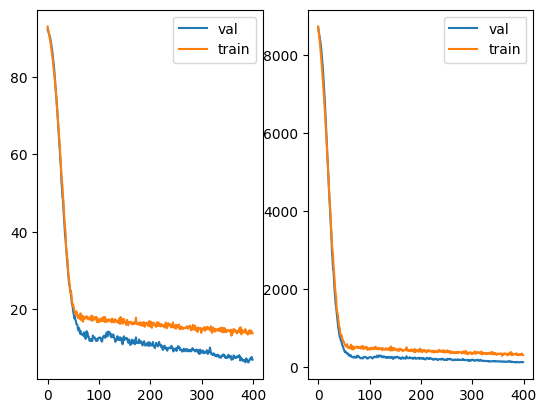

In [ ]:
estimator_history.keys()


fig, axes = plt.subplots(1, 2)

axes[0].plot(estimator_history["validation_abs"], label="val")
axes[0].plot(estimator_history["train_abs"], label="train")

axes[0].legend()



axes[1].plot(estimator_history["validation_mse"], label="val")
axes[1].plot(estimator_history["train_mse"], label="train")

axes[1].legend()

In [ ]:
import itertools
import torch

def brute_force_search_prune_config(
    model,
    estimator,
    input_shape,
    condition=lambda m, s, r, c: True,                 # list of filters
    objective=lambda m, s, r, c: m,                  # objective function, default objective = maximize metric
    maximize=True,                   # maximize or minimize?
    verbose=True
):
    """
    Generic brute-force search engine.

    Args:
        model: model with pruning methods
        estimator: metric estimator
        input_shape: input dimensions
        conditions: list of callables (metric,size,ram,comb)->bool
        objective: callable (metric,size,ram,comb)->float
        maximize: True=maximize objective, False=minimize
        verbose: print progress

    Returns:
        best_comb, best_obj_value, history
    """

    # initialize best value based on maximize/minimize
    if maximize:
        best_value = float("-inf")
    else:
        best_value = float("inf")

    best_comb = None

    # compute baseline size
    original_size = model.get_size_in_bytes()
    original_metric = estimator.predict(torch.Tensor([0, 0, 0]).unsqueeze(0))

    # helper to list all prune combinations
    def get_all_combinations(flat_dict):
        keys = list(flat_dict.keys())
        vals = list(flat_dict.values())
        for combo in itertools.product(*vals):
            yield {k: v for k, v in zip(keys, combo)}

    # iterate search space
    for comb in get_all_combinations(model.get_prune_channel_possible_hypermeters()):

        # predict metric
        metric = estimator.predict(
            torch.Tensor(list(comb.values())).unsqueeze(0)
        ) / original_metric

        # create compressed model
        compressed = model.init_compress({
            "prune_channel": {"sparsity": comb, "metric": "l2"}
        }, input_shape)

        size = compressed.get_size_in_bytes() / original_size
        ram = sum(compressed.get_max_workspace_arena(input_shape)) / 2

        # -------- HARD FILTERS --------
        if not condition(metric, size, ram, comb):
            continue

        # -------- OBJECTIVE VALUE --------
        obj = objective(metric, size, ram, comb)

        if (maximize and obj > best_value) or (not maximize and obj < best_value):
            best_value = obj
            best_comb = comb
            best_result_info = [metric, size, ram]
            if verbose:
                print(f"✔ New best: obj={obj:.4f}, metric={metric:.4f}, size={size:.4f}, ram={ram}, comb={comb}")

    return best_comb, best_result_info


## Getting the DMC model

### Searching for the smallest config with metric at least 99% of original

In [ ]:
best_comb, best_result_info = brute_force_search_prune_config(
    lenet5_model,
    estimator,
    INPUT_SHAPE,
    condition=lambda metric, size, ram_size, comb: metric > .99,                 # list of filters
    objective= lambda metric, size, ram_size, comb: size,                 # objective function
    maximize=False,                   # maximize or minimize?
    verbose=True
)
best_comb

✔ New best: obj=1.0000, metric=1.0000, size=1.0000, ram=4704.0, comb={'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 0, 'batchnorm2d_0': 0, 'relu_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_1': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_2': 0, 'linear_1': 0}
✔ New best: obj=0.9889, metric=1.0010, size=0.9889, ram=4704.0, comb={'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 1, 'batchnorm2d_0': 0, 'relu_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_1': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_2': 0, 'linear_1': 0}
✔ New best: obj=0.9779, metric=1.0019, size=0.9779, ram=4704.0, comb={'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 2, 'batchnorm2d_0': 0, 'relu_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_1': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_2': 0, 'linear_1': 0}
✔ New best: obj=0.9668, metric=1.0028, size=0.9668, ram=4704.0, comb={'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 3, 'batchnorm2d_0': 0, 'relu_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_1': 0, 'maxpool2d_1': 0, 

{'conv2d_0': 2,
 'conv2d_1': 4,
 'linear_0': 77,
 'batchnorm2d_0': 0,
 'relu_0': 0,
 'maxpool2d_0': 0,
 'batchnorm2d_1': 0,
 'relu_1': 0,
 'maxpool2d_1': 0,
 'flatten_0': 0,
 'relu_2': 0,
 'linear_1': 0}

In [ ]:
# Already precomputed
best_comb = {
    'conv2d_0':0,
    'conv2d_1': 9,
    'linear_0': 64,
    'batchnorm2d_0': 0,
    'relu_0': 0,
    'maxpool2d_0': 0,
    'batchnorm2d_1': 0,
    'relu_1': 0,
    'maxpool2d_1': 0,
    'flatten_0': 0,
    'relu_2': 0,
    'linear_1': 0
}


In [ ]:
early_stopper = EarlyStopper(
    monitor_metric="validation_loss",
    delta=1e-7,
    mode="min",
    patience=5,
    restore_best_state_dict=True,
)

def train_pruned(baseline_model, prune_sparsity_comb, train_loader, test_loader):
    print("\n--- STAGE 2: Applying Pruning & Retraining ---")
    
    # Pruning parameters from paper (Table 1 / Sec 4.1.1)
    pruning_config = {
        "prune_channel": {
            "sparsity": prune_sparsity_comb,
            "metric": "l2"
        }
    }
    
    print(f"Applying pruning config: {pruning_config['prune_channel']['sparsity']}")
    
    # Re-initialize model architecture with pruning
    pruned_model = copy.deepcopy(baseline_model)
    pruned_model = pruned_model.init_compress(pruning_config, INPUT_SHAPE).to(DEVICE)
    
    # Retrain (fine-tune) the pruned model
    print("Retraining pruned model (20 epochs)...")
    criterion_fun = nn.CrossEntropyLoss()
    optimizer_fun = optim.SGD(pruned_model.parameters(), lr=1.e-3, weight_decay=5e-4, momentum=.9)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_fun, mode="min", patience=1)

    pruned_model.fit(
        train_loader, 20, 
        criterion_fun, optimizer_fun, lr_scheduler,
        validation_dataloader=test_loader, 
        metrics={"acc": accuracy_fun},
        device=DEVICE, 
        callbacks=[early_stopper]
    )
    return pruned_model

def train_quantized_pruned(pruned_model, prune_sparsity_comb, train_loader, test_loader):
    print("\n--- STAGE 3: Applying Quantization (QAT) & Retraining ---")
    
    # Configs from paper (Table 2, 4-bit static) and notebook
    pruning_config = {
        "prune_channel": {
            "sparsity": prune_sparsity_comb,
            "metric": "l2"
        }
    }
    quantization_config = {
        "quantize": {
            "scheme": QuantizationScheme.STATIC,
            "granularity": QuantizationGranularity.PER_TENSOR,
            "bitwidth": 4
        }
    }
    full_compression_config = {**pruning_config, **quantization_config}

    print(f"Applying quantization config: 4-bit, STATIC, PER_TENSOR")
    
    # Get one batch of calibration data
    loader_iter = iter(test_loader)
    calibration_data = torch.concat([next(loader_iter)[0] for _ in range(5)], dim=0).to(DEVICE)
    print(calibration_data.size())
    
    # Re-initialize model with *both* configs
    quantized_model = copy.deepcopy(pruned_model)
    quantized_model = quantized_model.to(DEVICE) # Fuse before QAT

    # Initialize compression for QAT
    quantized_model = quantized_model.init_compress(
        full_compression_config, 
        INPUT_SHAPE, 
        calibration_data
    ).to(DEVICE)

    # Perform Quantization-Aware Training (15 epochs from paper Table 2)
    print("Performing QAT (15 epochs)...")
    criterion_fun = nn.CrossEntropyLoss()
    optimizer_fun = optim.SGD(quantized_model.parameters(), lr=1.e-4, weight_decay=5e-4, momentum=.9)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_fun, mode="min", patience=1)

    quantized_model.fit(
        train_loader, 20, 
        criterion_fun, optimizer_fun, lr_scheduler,
        validation_dataloader=test_loader, 
        metrics={"acc": accuracy_fun},
        device=DEVICE,
        callbacks=[early_stopper]
    )
    return quantized_model

# # --- Main Execution ---
# if __name__ == "__main__":
    
#     # Get Data
    
#     # --- STAGE 1: BASELINE ---
#     baseline_model = copy.deepcopy(lenet5_model)
    
#     print("Evaluating baseline model...")
#     baseline_eval = baseline_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, device=DEVICE)
#     original_size = baseline_model.get_size_in_bits() // 8
#     print(f"==> STAGE 1 (Baseline) COMPLETE ==")
#     print(f"    Accuracy: {baseline_eval['acc']:.2f}%")
#     print(f"    Size:     {original_size} bytes")

#     # --- STAGE 2: PRUNED ---
#     # Use a copy to keep the original baseline model clean
#     pruned_model = train_pruned(baseline_model, best_comb, mnist_train_loader, mnist_test_loader)
    
#     print("Evaluating pruned model...")
#     pruned_eval = pruned_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, device=DEVICE)
#     pruned_size = pruned_model.get_size_in_bits() // 8
#     print(f"\n==> STAGE 2 (Pruned) COMPLETE ==")
#     print(f"    Accuracy: {pruned_eval['acc']:.2f}%")
#     print(f"    Size:     {pruned_size} bytes ({pruned_size/original_size*100:.2f}% of original)")

#     print(f"\n===> Layerwise Prunning Results:")
#     for i, (name, module) in enumerate(pruned_model.names_layers()):
#         if ("conv2d" in name) or ("linear" in name):
#             print(f"    Layer name : {name}, Original size {baseline_model[i].get_size_in_bits()/(8*1024)} Reduced size {module.get_size_in_bits()/(8*1024)}:  Size Ratio: {(1 - module.get_size_in_bits()/baseline_model[i].get_size_in_bits())*100:.2f}%") # type: ignore

#     # --- STAGE 3: QUANTIZED-PRUNED ---
#     quantized_model = train_quantized_pruned(pruned_model, best_comb, mnist_train_loader, mnist_test_loader)
    
#     print("Evaluating final quantized-pruned model...")
#     quantized_eval = quantized_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, device=DEVICE)
#     quantized_size = quantized_model.get_size_in_bits() // 8
#     print(f"\n==> STAGE 3 (Quantized-Pruned) COMPLETE ==")f
#     print(f"    Accuracy: {quantized_eval['acc']:.2f}%")
#     print(f"    Size:     {quantized_size} bytes ({quantized_size/original_size*100:.2f}% of original)")

#     print(f"\n===> Layerwise Pruned and Quantized Results:")
#     for i, (name, module) in enumerate(quantized_model.names_layers()):
#         if ("conv2d" in name) or ("linear" in name):
#             print(f"    Layer name : {name}, Original size {baseline_model[i].get_size_in_bits()/(8*1024):8.4f} Reduced size {module.get_size_in_bits()/(8*1024):8.4f}:  Size Ratio: {(1 - module.get_size_in_bits()/baseline_model[i].get_size_in_bits())*100:.2f}%") # type: ignore

#     print("\n--- REPRODUCTION FINISHED ---")
#     print("\nFinal Results Summary:")
#     print(f"Baseline:   {baseline_eval['acc']:.2f}% Acc, {original_size} bytes")
#     print(f"Pruned:     {pruned_eval['acc']:.2f}% Acc, {pruned_size} bytes, {pruned_size/original_size*100:.2f}% of original")
#     print(f"Quantized:  {quantized_eval['acc']:.2f}% Acc, {quantized_size} bytes, {quantized_size/original_size*100:.2f}% of original")

## To Inference Stats 


In [ ]:
base_total_b, prune_total_b, quant_total_b = 0, 0, 0
# input_shape = [
#     (1, 1, 28, 28),
#     (1, 6)
# ]
for baseline_layer, prune_layer, quant_layer in zip(baseline_model.fuse().to(DEVICE), pruned_model.fuse().to(DEVICE), quantized_model.fuse().to(DEVICE)):
    
    if isinstance(baseline_layer, (MaxPool2d, Flatten)):
        continue
    # total += layer.get_size_in_bits()

    base_size_b = baseline_layer.get_size_in_bits()
    prune_size_b = prune_layer.get_size_in_bits()
    quant_size_b = quant_layer.get_size_in_bits()
    
    print(baseline_layer)
    print(
        f"baseline_layer size in KB {base_size_b/(1024*8):10.4f}\n"
        f"prune_layer size reduction ratio {(base_size_b -prune_size_b)/base_size_b:10.4f}\n"
        f"quant_layer size reduction ratio {(base_size_b -quant_size_b)/base_size_b:10.4f}\n"
    )
    base_total_b += base_size_b
    prune_total_b += prune_size_b
    quant_total_b += quant_size_b

print(baseline_model)
print(
    f"baseline_model size in KB {base_total_b/(1024*8):10.4f}\n"
    f"prune_model size reduction ratio {(base_total_b -prune_total_b)/base_total_b:10.4f}, in KB {prune_total_b/(1024*8):10.4f}\n"
    f"quant_model size reduction ratio {(base_total_b -quant_total_b)/base_total_b:10.4f}, in KB {quant_total_b/(1024*8):10.4f}\n"
)

Conv2dReLU(
  1, 6, kernel_size=(5, 5), stride=(1, 1)
  (relu): ReLU()
)
baseline_layer size in KB     0.6094
prune_layer size reduction ratio     0.0000
quant_layer size reduction ratio     0.8253

Conv2dReLU(
  6, 16, kernel_size=(5, 5), stride=(1, 1)
  (relu): ReLU()
)
baseline_layer size in KB     9.4375
prune_layer size reduction ratio     0.5625
quant_layer size reduction ratio     0.9417

LinearReLU(
  in_features=400, out_features=84, bias=True
  (relu): ReLU()
)
baseline_layer size in KB   131.5781
prune_layer size reduction ratio     0.8955
quant_layer size reduction ratio     0.9863

Linear(in_features=84, out_features=10, bias=True)
baseline_layer size in KB     3.3203
prune_layer size reduction ratio     0.7529
quant_layer size reduction ratio     0.9559

Sequential(
  (conv2d_0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2d_0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_0): ReLU()
  (maxpool2d_0): MaxPool2d(ker

In [ ]:
test_input, test_ = mnist_test_dataset[0]
test_input = test_input.unsqueeze(0).to(DEVICE)

In [ ]:
# fused_model = lenet5_model.fuse().to(DEVICE).eval()
# fused_model.convert_to_c(INPUT_SHAPE, "lenet_model", arduino_src_dir, arduino_include_dir, test_input)

# fused_model(test_input)

In [ ]:
# fused_model = pruned_model.fuse().to(DEVICE).eval()
# fused_model.convert_to_c(INPUT_SHAPE, "lenet_model", arduino_src_dir, arduino_include_dir, test_input)

# fused_model(test_input)

In [ ]:
# fused_model = quantized_model.fuse().to(DEVICE).eval()
# fused_model.convert_to_c(INPUT_SHAPE, "lenet_model", arduino_src_dir, arduino_include_dir, test_input)

# fused_model.output_quantize.apply(fused_model(test_input))

## Getting the best model for Atlmega360
We set the max activation to be the ram size of 2KB and the size at most 20%. 

In [ ]:
brute_force_search_prune_config(
    lenet5_model,
    estimator,
    INPUT_SHAPE,
    condition=lambda metric, size, ram_size, comb: ram_size < 1.5 * 1024 and size < 0.2,                 # list of filters
    objective= lambda metric, size, ram_size, comb: metric,                 # objective function
    maximize=True,                   # maximize or minimize?
    verbose=True
)

NameError: name 'brute_force_search_prune_config' is not defined

In [15]:
ardunio_config = {'conv2d_0':4,
    'conv2d_1': 7,
    'linear_0': 55,
    'batchnorm2d_0': 0,
    'relu_0': 0,
    'maxpool2d_0': 0,
    'batchnorm2d_1': 0,
    'relu_1': 0,
    'maxpool2d_1': 0,
    'flatten_0': 0,
    'relu_2': 0,
    'linear_1': 0
}

In [16]:
# ardunio_config = {'conv2d_0':5,
#     'conv2d_1': 7,
#     'linear_0': 55,
#     'batchnorm2d_0': 0,
#     'relu_0': 0,
#     'maxpool2d_0': 0,
#     'batchnorm2d_1': 0,
#     'relu_1': 0,
#     'maxpool2d_1': 0,
#     'flatten_0': 0,
#     'relu_2': 0,
#     'linear_1': 0
# }

In [17]:
pruning_config = {
    "prune_channel": {
        "sparsity": ardunio_config,
        "metric": "l2"
    }
}

quantization_config = {
    "quantize": {
        "scheme": QuantizationScheme.STATIC,
        "granularity": QuantizationGranularity.PER_TENSOR,
        "bitwidth": 4
    }
}
full_compression_config = {**pruning_config, **quantization_config}


uno_pruned_model = train_pruned(lenet5_model, ardunio_config, mnist_train_loader, mnist_test_loader)
uno_quantized_model = train_quantized_pruned(uno_pruned_model, ardunio_config, mnist_train_loader, mnist_test_loader)

# # Get one batch of calibration data
# loader_iter = iter(mnist_test_loader)
# calibration_data = torch.concat([next(loader_iter)[0] for _ in range(5)], dim=0).to(DEVICE)

# # Initialize compression for QAT
# uno_model = lenet5_model.init_compress(
#     full_compression_config, 
#     INPUT_SHAPE, 
#     calibration_data
# ).to(DEVICE)

fused_model = uno_quantized_model.fuse().to(DEVICE).eval()
fused_model.convert_to_c(INPUT_SHAPE, "uno_model", arduino_uno_src_dir, arduino_uno_include_dir, test_input)
fused_model.convert_to_c(INPUT_SHAPE, "uno_model", hp_src_dir, hp_include_dir, test_input)
fused_model.get_max_workspace_arena(INPUT_SHAPE)
# fused_model.output_quantize.apply(fused_model(test_input))
# uno_quantized_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, DEVICE)


--- STAGE 2: Applying Pruning & Retraining ---
Applying pruning config: {'conv2d_0': 4, 'conv2d_1': 7, 'linear_0': 55, 'batchnorm2d_0': 0, 'relu_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_1': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_2': 0, 'linear_1': 0}
Retraining pruned model (20 epochs)...


DMC Training (Epochs 1-20):   0%|          | 0/20 [00:00<?, ?it/s]

DMC Training (Epochs 1-20):   0%|          | 0/20 [00:17<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
fused_model.get_max_workspace_arena(INPUT_SHAPE)

(392, 576)

In [ ]:
fused_model.convert_to_c(INPUT_SHAPE, "uno_model", arduino_uno_src_dir, arduino_uno_include_dir, test_input)


In [ ]:
uno_quantized_model.to(DEVICE).evaluate(mnist_test_loader, {"acc": accuracy_fun}, DEVICE)

100%|██████████| 313/313 [00:04<00:00, 66.61it/s]


{'acc': 94.91}

In [ ]:
uno_quantized_model._modules.pop("batchnorm2d_0", "batchnorm2d_1")

BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
uno_quantized_model

Sequential(
  (conv2d_0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu_0): ReLU()
  (maxpool2d_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_1): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2d_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU()
  (maxpool2d_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten_0): Flatten(start_dim=1, end_dim=-1)
  (linear_0): Linear(in_features=400, out_features=84, bias=True)
  (relu_2): ReLU()
  (linear_1): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
uno_quantized_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, DEVICE)

100%|██████████| 313/313 [00:04<00:00, 66.91it/s]


{'acc': 11.21}

In [ ]:
train_quantized_pruned(uno_quantized_model.fuse().to(DEVICE),  {'conv2d_0':4,
    'conv2d_1': 7,
    'linear_0': 55,
    'maxpool2d_0': 0,
    'maxpool2d_1': 0,
    'flatten_0': 0,
    'linear_1': 0
}, mnist_train_loader, mnist_test_loader)


--- STAGE 3: Applying Quantization (QAT) & Retraining ---
Applying quantization config: 4-bit, STATIC, PER_TENSOR
torch.Size([160, 1, 28, 28])
Performing QAT (15 epochs)...


  5%|▌         | 1/20 [01:15<23:59, 75.75s/it]

epoch    0 | train loss 0.0910 | validation loss 0.0722 | train acc 10.8450 | validation acc 11.3500


  5%|▌         | 1/20 [01:27<27:47, 87.78s/it]


KeyboardInterrupt: 

In [ ]:
total = 0
for layer in uno_quantized_model:
    total += layer.get_size_in_bytes()
    print(layer, layer.get_size_in_bytes(), total)

total = 0
for layer in uno_quantized_model.fuse().to(DEVICE):
    total += layer.get_size_in_bytes()
    print(layer, layer.get_size_in_bytes(), total)



Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1)) 43 43
ReLU() 1 44
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 0 44
Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)) 271 315
BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 72 387
ReLU() 1 388
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 0 388
Flatten(start_dim=1, end_dim=-1) 0 388
Linear(in_features=400, out_features=84, bias=True) 3389 3777
ReLU() 1 3778
Linear(in_features=84, out_features=10, bias=True) 195 3973
Conv2dReLU(
  1, 6, kernel_size=(5, 5), stride=(1, 1)
  (relu): ReLU()
) 43 43
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 0 43
Conv2dReLU(
  6, 16, kernel_size=(5, 5), stride=(1, 1)
  (relu): ReLU()
) 271 314
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 0 314
Flatten(start_dim=1, end_dim=-1) 0 314
LinearReLU(
  in_features=400, out_features=84, bias=True
  (relu): ReLU()
) 338

In [ ]:
best_metric = float("-inf")
best_comb = None
best_size = float("inf")
original_size = lenet5_model.get_size_in_bytes()

def get_all_combinations(flat_dict: dict[str, list]):
    keys = list(flat_dict.keys())
    values = list(flat_dict.values())
    product = itertools.product(*values)

    for comb in product:
        yield {key: value for key, value in zip(keys, comb)}

        
result = []

original_metric = estimator.predict(torch.Tensor([0, 0, 0]).unsqueeze(0))
print(original_metric)

for prune_comb in get_all_combinations(lenet5_model.get_prune_channel_possible_hypermeters()):
    metric = estimator.predict(torch.Tensor(list(prune_comb.values())).unsqueeze(0))

    compression_config = {
        "prune_channel" :{
            "sparsity" : prune_comb,
            "metric" : "l2"
        },
    }

    # if metric > 0.985 * original_metric:
    compressed_model = lenet5_model.init_compress(compression_config, INPUT_SHAPE)
    size = compressed_model.get_size_in_bytes() / original_size
    ram_size = sum(compressed_model.get_max_workspace_arena(INPUT_SHAPE)) / 2

    if ram_size < 2 * 1024 and size < 0.2:
        if metric > best_metric:
            best_comb = prune_comb
            best_metric = metric
            print(metric, size, best_comb, ram_size)
    # if lenet5_model.init_compress(compression_config, input_shape).get_size_in_bytes() / original_size < 5:

    #     result.append((prune_comb, metric))

        if metric > best_metric:
            best_metric = metric
            best_comb = prune_comb

            print(best_comb, best_metric)


NameError: name 'estimator' is not defined

In [ ]:
input_shape = INPUT_SHAPE
for layer in quantized_model.layers():
    max_shape, input_shape = layer.get_output_tensor_shape(input_shape)
    print(layer, max_shape, max_shape.numel())
quantized_model.get_max_workspace_arena(INPUT_SHAPE)

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1)) torch.Size([1, 32, 32]) 1024
BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) torch.Size([4, 28, 28]) 3136
ReLU() torch.Size([4, 28, 28]) 3136
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) torch.Size([4, 14, 14]) 784
Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)) torch.Size([4, 14, 14]) 784
BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) torch.Size([6, 10, 10]) 600
ReLU() torch.Size([6, 10, 10]) 600
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) torch.Size([6, 5, 5]) 150
Flatten(start_dim=1, end_dim=-1) torch.Size([150]) 150
Linear(in_features=400, out_features=84, bias=True) torch.Size([25]) 25
ReLU() torch.Size([25]) 25
Linear(in_features=84, out_features=10, bias=True) torch.Size([10]) 10


(3136, 3136)

In [ ]:
quantized_model.convert_to_c(INPUT_SHAPE, "P_Q_LENET5", src_dir="Arduino Nano 33 BLE/src", include_dir="Arduino Nano 33 BLE/src")


In [ ]:

    criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(lenet5_model.parameters(), lr=1.e-3)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=2)

param += lenet5_model.get_nas_prune_channel(input_shape, mnist_test_loader, accuracy_fun, DEVICE, num_data=400, 
                                            train=True,
    train_dataloader=mnist_train_loader, epochs=2, criterion_fun=criterion_fun, optimizer_fun=optimizion_fun,
    lr_scheduler=lr_scheduler, )
estimator = Estimator(param, device=DEVICE, hidden_dim=[128, 128, 128], dropout=.75)
estimator_history = estimator.fit(epochs=500)


IndentationError: unexpected indent (567008283.py, line 1)

In [ ]:
len(torch.load("get_nas_param_with_training"))

500

In [ ]:
torch.save(param, "get_nas_param_with_training")

In [ ]:
estimator_history

{'validation_loss': [tensor(355.1248, device='cuda:0'),
  tensor(340.5578, device='cuda:0'),
  tensor(290.3071, device='cuda:0'),
  tensor(165.1139, device='cuda:0'),
  tensor(28.1457, device='cuda:0'),
  tensor(16.0072, device='cuda:0'),
  tensor(26.4479, device='cuda:0'),
  tensor(22.1945, device='cuda:0'),
  tensor(19.8258, device='cuda:0'),
  tensor(24.0395, device='cuda:0'),
  tensor(19.7391, device='cuda:0'),
  tensor(18.6076, device='cuda:0'),
  tensor(20.1053, device='cuda:0'),
  tensor(19.2924, device='cuda:0'),
  tensor(22.1729, device='cuda:0'),
  tensor(16.7815, device='cuda:0'),
  tensor(15.4645, device='cuda:0'),
  tensor(16.6608, device='cuda:0'),
  tensor(17.6951, device='cuda:0'),
  tensor(18.9514, device='cuda:0'),
  tensor(16.7353, device='cuda:0'),
  tensor(14.6157, device='cuda:0'),
  tensor(12.9355, device='cuda:0'),
  tensor(14.9380, device='cuda:0'),
  tensor(15.6660, device='cuda:0'),
  tensor(18.0503, device='cuda:0'),
  tensor(14.1748, device='cuda:0'),
  ten

In [ ]:
len(param)

500

In [ ]:

best_metric = float("-inf")
best_comb = None
best_size = float("inf")
original_size = lenet5_model.get_size_in_bytes()


def get_all_combinations(flat_dict: dict[str, list]):
    keys = list(flat_dict.keys())
    values = list(flat_dict.values())
    product = itertools.product(*values)

    for comb in product:
        yield {key: value for key, value in zip(keys, comb)}

        
result = []

original_metric = estimator.predict(torch.Tensor([0, 0, 0]))
print(original_metric)

for prune_comb in get_all_combinations(lenet5_model.get_prune_channel_possible_hypermeters()):
    metric = estimator.predict(torch.Tensor(list(prune_comb.values())))

    compression_config = {
        "prune_channel" :{
            "sparsity" : prune_comb,
            "metric" : "l2"
        },
    }

    if metric > 0.965 * original_metric:
        
        size = lenet5_model.init_compress(compression_config, input_shape).get_size_in_bytes() / original_size
        if size < best_size:
            best_comb = prune_comb
            best_size = size
            print(metric, size, best_comb)
    # if lenet5_model.init_compress(compression_config, input_shape).get_size_in_bytes() / original_size < 5:

    #     result.append((prune_comb, metric))

    #     if metric > best_metric:
    #         best_metric = metric
    #         best_comb = prune_comb

    #         print(best_comb, best_metric)


95.9630126953125
95.9630126953125 1.0 {'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 0, 'batchnorm2d_0': 0, 'relu6_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_0': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_1': 0, 'linear_1': 0}
95.97836303710938 0.9889368591473287 {'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 1, 'batchnorm2d_0': 0, 'relu6_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_0': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_1': 0, 'linear_1': 0}
95.99087524414062 0.9778737182946573 {'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 2, 'batchnorm2d_0': 0, 'relu6_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_0': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_1': 0, 'linear_1': 0}
96.0018081665039 0.966810577441986 {'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 3, 'batchnorm2d_0': 0, 'relu6_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_0': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_1': 0, 'linear_1': 0}
96.01089477539062 0.9557474365893146 {'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 4

In [ ]:
best_comb

{'conv2d_0': 0,
 'conv2d_1': 15,
 'linear_0': 0,
 'batchnorm2d_0': 0,
 'relu6_0': 0,
 'maxpool2d_0': 0,
 'batchnorm2d_1': 0,
 'relu_0': 0,
 'maxpool2d_1': 0,
 'flatten_0': 0,
 'relu_1': 0,
 'linear_1': 0}

In [ ]:
best_pruned_model = lenet5_model.init_compress({
    "prune_channel": {
        "sparsity": {
            "conv2d_0": 0,
            "conv2d_1": 9,
            "linear_0": 50
        },
        "metric": "l2"
    }
}, input_shape).to(DEVICE)


criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(best_pruned_model.parameters(), lr=1.e-3, weight_decay=5e-4, momentum=.9)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=1)

best_pruned_model.fit(
    mnist_train_loader, 20, 
    criterion_fun, optimizion_fun, lr_scheduler,
    validation_dataloader=mnist_test_loader, 
    metrics={"acc" : accuracy_fun},
    # callbacks=[early_stopper],
    device=DEVICE
)


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:12<03:48, 12.03s/it]

epoch    0 | train loss 0.0050 | validation loss 0.0032 | train acc 95.0417 | validation acc 96.6500


 10%|█         | 2/20 [00:25<03:47, 12.62s/it]

epoch    1 | train loss 0.0029 | validation loss 0.0024 | train acc 97.2533 | validation acc 97.5100


 15%|█▌        | 3/20 [00:37<03:35, 12.66s/it]

epoch    2 | train loss 0.0025 | validation loss 0.0020 | train acc 97.5417 | validation acc 97.8700


 20%|██        | 4/20 [00:50<03:21, 12.62s/it]

epoch    3 | train loss 0.0022 | validation loss 0.0019 | train acc 97.7300 | validation acc 98.0700


 25%|██▌       | 5/20 [01:03<03:11, 12.76s/it]

epoch    4 | train loss 0.0020 | validation loss 0.0017 | train acc 98.0117 | validation acc 98.2100


 30%|███       | 6/20 [01:16<02:59, 12.85s/it]

epoch    5 | train loss 0.0020 | validation loss 0.0018 | train acc 98.0317 | validation acc 98.4000


 35%|███▌      | 7/20 [01:29<02:48, 12.98s/it]

epoch    6 | train loss 0.0019 | validation loss 0.0017 | train acc 98.0967 | validation acc 98.3100


 40%|████      | 8/20 [01:44<02:44, 13.69s/it]

epoch    7 | train loss 0.0018 | validation loss 0.0017 | train acc 98.2083 | validation acc 98.1800


 45%|████▌     | 9/20 [02:02<02:45, 15.07s/it]

epoch    8 | train loss 0.0017 | validation loss 0.0017 | train acc 98.2467 | validation acc 98.3100


 50%|█████     | 10/20 [02:15<02:23, 14.31s/it]

epoch    9 | train loss 0.0017 | validation loss 0.0016 | train acc 98.2750 | validation acc 98.3700


 55%|█████▌    | 11/20 [02:28<02:04, 13.82s/it]

epoch   10 | train loss 0.0016 | validation loss 0.0015 | train acc 98.3217 | validation acc 98.3200


 60%|██████    | 12/20 [02:40<01:46, 13.32s/it]

epoch   11 | train loss 0.0015 | validation loss 0.0015 | train acc 98.4217 | validation acc 98.4800


 65%|██████▌   | 13/20 [02:52<01:30, 12.96s/it]

epoch   12 | train loss 0.0016 | validation loss 0.0014 | train acc 98.3817 | validation acc 98.6000


 70%|███████   | 14/20 [03:04<01:16, 12.67s/it]

epoch   13 | train loss 0.0016 | validation loss 0.0015 | train acc 98.4567 | validation acc 98.4500


 75%|███████▌  | 15/20 [03:16<01:02, 12.54s/it]

epoch   14 | train loss 0.0015 | validation loss 0.0013 | train acc 98.5000 | validation acc 98.6100


 80%|████████  | 16/20 [03:29<00:50, 12.61s/it]

epoch   15 | train loss 0.0015 | validation loss 0.0016 | train acc 98.4400 | validation acc 98.3900


 85%|████████▌ | 17/20 [03:42<00:37, 12.58s/it]

epoch   16 | train loss 0.0015 | validation loss 0.0013 | train acc 98.4917 | validation acc 98.5100


 90%|█████████ | 18/20 [03:54<00:25, 12.56s/it]

epoch   17 | train loss 0.0014 | validation loss 0.0015 | train acc 98.6433 | validation acc 98.4200


 95%|█████████▌| 19/20 [04:09<00:13, 13.12s/it]

epoch   18 | train loss 0.0013 | validation loss 0.0013 | train acc 98.6550 | validation acc 98.5700


100%|██████████| 20/20 [04:22<00:00, 13.14s/it]

epoch   19 | train loss 0.0013 | validation loss 0.0015 | train acc 98.6933 | validation acc 98.5900


{'validation_loss': [tensor(0.0032, device='cuda:0'),
  tensor(0.0024, device='cuda:0'),
  tensor(0.0020, device='cuda:0'),
  tensor(0.0019, device='cuda:0'),
  tensor(0.0017, device='cuda:0'),
  tensor(0.0018, device='cuda:0'),
  tensor(0.0017, device='cuda:0'),
  tensor(0.0017, device='cuda:0'),
  tensor(0.0017, device='cuda:0'),
  tensor(0.0016, device='cuda:0'),
  tensor(0.0015, device='cuda:0'),
  tensor(0.0015, device='cuda:0'),
  tensor(0.0014, device='cuda:0'),
  tensor(0.0015, device='cuda:0'),
  tensor(0.0013, device='cuda:0'),
  tensor(0.0016, device='cuda:0'),
  tensor(0.0013, device='cuda:0'),
  tensor(0.0015, device='cuda:0'),
  tensor(0.0013, device='cuda:0'),
  tensor(0.0015, device='cuda:0')],
 'validation_acc': [96.65,
  97.51,
  97.87,
  98.07,
  98.21,
  98.4,
  98.31,
  98.18,
  98.31,
  98.37,
  98.32,
  98.48,
  98.6,
  98.45,
  98.61,
  98.39,
  98.51,
  98.42,
  98.57,
  98.59],
 'train_loss': [0.0050320519860213,
  0.0028521709499317997,
  0.002507683808061604

In [ ]:
next(iter(mnist_test_loader))[0].shape

torch.Size([32, 1, 28, 28])

In [ ]:
best_pruned_model = torch.load("best_pruned_model{'conv2d_0': 5, 'conv2d_1': 15, 'linear_0': 83}", weights_only=False)

In [ ]:
best_pruned_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, device=DEVICE)

100%|██████████| 313/313 [00:01<00:00, 226.66it/s]


{'acc': 98.59}

In [ ]:
quantized_model = best_pruned_model.init_compress({
    "prune_channel": {
        "sparsity": {
            "conv2d_0": 0,
            "conv2d_1": 9,
            "linear_0": 50
        },
        "metric": "l2"
    },
    "quantize": {
        "scheme": QuantizationScheme.STATIC,
        "granularity": QuantizationGranularity.PER_TENSOR,
        "bitwidth": 4
    }
}, input_shape, next(iter(mnist_test_loader))[0].to(DEVICE)).to(DEVICE)


criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(quantized_model.parameters(), lr=1.e-4, weight_decay=5e-4, momentum=.9)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=1)

quantized_model.fit(
    mnist_train_loader, 3, 
    criterion_fun, optimizion_fun, lr_scheduler,
    validation_dataloader=mnist_test_loader, 
    metrics={"acc" : accuracy_fun},
    # callbacks=[early_stopper],
    device=DEVICE
)


 33%|███▎      | 1/3 [00:26<00:52, 26.02s/it]

epoch    0 | train loss 0.0031 | validation loss 0.0030 | train acc 96.5533 | validation acc 96.7300


 67%|██████▋   | 2/3 [00:52<00:26, 26.31s/it]

epoch    1 | train loss 0.0029 | validation loss 0.0025 | train acc 96.7217 | validation acc 97.3000


100%|██████████| 3/3 [01:20<00:00, 26.74s/it]

epoch    2 | train loss 0.0028 | validation loss 0.0027 | train acc 96.9067 | validation acc 97.2900


{'validation_loss': [tensor(0.0030, device='cuda:0'),
  tensor(0.0025, device='cuda:0'),
  tensor(0.0027, device='cuda:0')],
 'validation_acc': [96.73, 97.3, 97.29],
 'train_loss': [0.003146008840368207,
  0.0029256463757017627,
  0.002808011225054118],
 'train_acc': [96.55333333333333, 96.72166666666666, 96.90666666666667]}

In [ ]:
quantized_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, device=DEVICE)


100%|██████████| 313/313 [00:01<00:00, 158.98it/s]


{'acc': 98.49}

In [ ]:
nn.Conv1d

In [ ]:
quantized_model.get_size_in_bytes()

7706

In [ ]:
torch.save(best_pruned_model, f"best_pruned_model{prune_comb}")

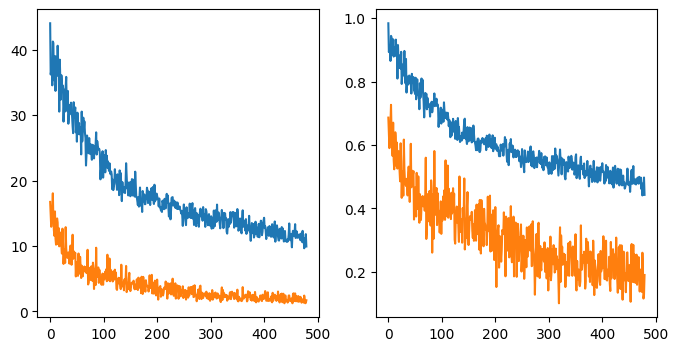

In [ ]:
start_num = 20

fig, axes = plt.subplots(1,2, figsize = (8, 4))
axes[0].plot(range(len(estimator_history["train_loss"])-start_num), estimator_history["train_loss"][start_num:])
axes[0].plot(range(len(estimator_history["validation_loss"])-start_num), list(map(lambda x: x.detach().cpu().numpy(), estimator_history["validation_loss"]))[start_num:])

axes[1].plot(range(len(estimator_history["train_abs"])-start_num), estimator_history["train_abs"][start_num:])
axes[1].plot(range(len(estimator_history["validation_abs"])-start_num), estimator_history["validation_abs"][start_num:])

In [ ]:
estimator.predict(torch.Tensor([0,0,7]))

94.1739501953125

In [ ]:
lenet5_model["linear_0"].get_size_in_bits()//8

134400

In [ ]:
best_pruned_model['linear_0'].get_size_in_bits()//8


23800

In [ ]:
early_stopper = EarlyStopper(
    metric_name="validation_loss",
    min_valid_diff=1e-4,
    mode="min",
    patience=2,
    restore_best_state_dict=True,
)

criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(lenet5_model.parameters(), lr=1.e-3)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=2)



sensitivity = lenet5_model.get_layers_prune_channel_sensity_(
    input_shape=input_shape, data_loader=mnist_test_loader, metrics={"acc":accuracy_fun, "acc1":accuracy_fun}, device=DEVICE,
    train=False,
    train_dataloader=mnist_train_loader, epochs=2, criterion_fun=criterion_fun, optimizer_fun=optimizion_fun,
    lr_scheduler=lr_scheduler, 
)

AttributeError: 'Sequential' object has no attribute 'get_layers_prune_channel_sensity_'

6 [(0.0, 99.22), (0.16666666666666666, 97.47), (0.3333333333333333, 71.31), (0.5, 40.65), (0.6666666666666666, 28.36), (0.8333333333333334, 13.94)]
16 [(0.0, 99.05), (0.0625, 98.92), (0.125, 98.33), (0.1875, 96.8), (0.25, 93.52), (0.3125, 93.96), (0.375, 94.0), (0.4375, 88.09), (0.5, 84.76), (0.5625, 76.28), (0.625, 71.09), (0.6875, 67.97), (0.75, 58.37), (0.8125, 32.16), (0.875, 22.52), (0.9375, 21.5)]
84 [(0.0, 99.05), (0.011904761904761904, 99.08), (0.023809523809523808, 99.04), (0.03571428571428571, 99.2), (0.047619047619047616, 98.98), (0.05952380952380952, 99.19), (0.07142857142857142, 99.16), (0.08333333333333333, 99.09), (0.09523809523809523, 99.09), (0.10714285714285714, 99.11), (0.11904761904761904, 99.18), (0.13095238095238096, 99.07), (0.14285714285714285, 99.1), (0.15476190476190477, 99.08), (0.16666666666666666, 99.03), (0.17857142857142858, 99.28), (0.19047619047619047, 99.25), (0.20238095238095238, 99.17), (0.21428571428571427, 99.14), (0.2261904761904762, 99.07), (0.23

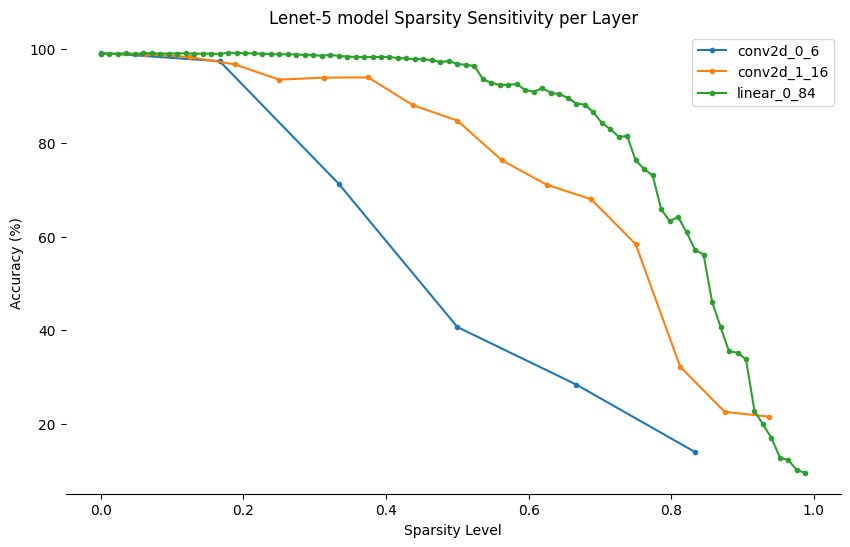

In [ ]:
plt.figure(figsize=(10, 6))
for layer, values in sensitivity['acc'].items():
    print(len(values), values)
    sparsity, acc = zip(*values)
    plt.plot(sparsity, acc, marker='.', label=layer+f"_{str(len(values))}")

plt.xlabel("Sparsity Level")
plt.ylabel("Accuracy (%)")
plt.title("Lenet-5 model Sparsity Sensitivity per Layer")
plt.legend()
plt.grid(False)

list(plt.gca().spines.values())[0].set_visible(False)
list(plt.gca().spines.values())[1].set_visible(False)
list(plt.gca().spines.values())[3].set_visible(False)

plt.savefig("Lenet-5 model Sparsity Sensitivity per Layer", dpi=300, bbox_inches="tight")
plt.show()


4

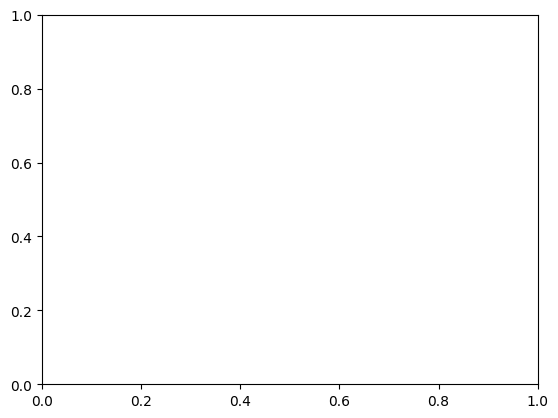

In [ ]:
len(plt.gca().spines.values())

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from itertools import product

# Your dataset
acc_data = {
    'conv2d_0': [(0.0, 99.22), (0.1667, 97.47), (0.3333, 71.31), (0.5, 40.65), (0.6667, 28.36), (0.8333, 13.94)],
    'conv2d_1': [(0.0, 99.05), (0.0625, 98.92), (0.125, 98.33), (0.1875, 96.8), (0.25, 93.52), (0.3125, 93.96),
                 (0.375, 94.0), (0.4375, 88.09), (0.5, 84.76), (0.5625, 76.28), (0.625, 71.09), (0.6875, 67.97),
                 (0.75, 58.37), (0.8125, 32.16), (0.875, 22.52), (0.9375, 21.5)],
    'linear_0': [
        (0.0, 99.05), (0.1667, 99.03), (0.3333, 98.61), (0.5, 96.88), (0.6667, 88.4),
        (0.75, 76.29), (0.8333, 57.14), (0.9167, 22.73), (1.0, 9.52)
    ]
}

# Build dataset as combinations of sparsities
X, y = [], []
for s0, _ in acc_data['conv2d_0']:
    for s1, _ in acc_data['conv2d_1']:
        for s2, acc in acc_data['linear_0']:
            # Features = sparsity levels
            X.append([s0, s1, s2])
            # Approx target = min accuracy among layers (proxy)
            y.append(acc)  

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.layers(x)

model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(500):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Example prediction
test_sparsity = torch.tensor([[0.5, 0.25, 0.33]])  # (conv2d_0, conv2d_1, linear_0)
pred_acc = model(test_sparsity).item()
print(f"Predicted Accuracy: {pred_acc:.2f}%")


Epoch 100, Loss: 5958.7373
Epoch 200, Loss: 4314.2148
Epoch 300, Loss: 2123.2832
Epoch 400, Loss: 1662.4471
Epoch 500, Loss: 1510.1141
Predicted Accuracy: 58.12%


## Original Model


In [ ]:
lenet5_mcu_model = copy.deepcopy(lenet5_model)

evaluate_result = lenet5_mcu_model.evaluate(mnist_test_loader, {"acc":accuracy_fun}, device=DEVICE)
original_size = lenet5_mcu_model.get_size_in_bits()//8
print(f"The original model accuracy is {evaluate_result["acc"]*100:.2f}% with size {original_size} bytes.")

# lenet5_mcu_model.convert_to_c(var_name="lenet5_mcu_model", src_dir="./Arduino Nano 33 BLE/src/", include_dir="./Arduino Nano 33 BLE/include/")
lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")

print(lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"))
evaluate_result["acc"], original_size

100%|██████████| 313/313 [00:01<00:00, 239.41it/s]


The original model accuracy is 9915.00% with size 148240 bytes.
tensor([[-29.0016, -22.3953, -21.4715,  30.5191, -33.2081,   0.8119, -33.4459,
         -16.0511,  -6.0006,  -9.6175]], device='cuda:0')


(99.15, 148240)

In [ ]:
fused_lenet5_mcu_model = lenet5_mcu_model.fuse().to(DEVICE)

evaluate_result = fused_lenet5_mcu_model.evaluate(mnist_test_loader, {"acc":accuracy_fun}, device=DEVICE)
original_size = fused_lenet5_mcu_model.get_size_in_bits()//8
print(f"The original model accuracy is {evaluate_result["acc"]*100:.2f}% with size {original_size} bytes.")

# fused_lenet5_mcu_model.convert_to_c(var_name="lenet5_mcu_model", src_dir="./Arduino Nano 33 BLE/src/", include_dir="./Arduino Nano 33 BLE/include/")
fused_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")

print(fused_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"))
# print(fused_lenet5_mcu_model(lenet5_mcu_model.test_input[0].unsqueeze(dim=0).detach().clone()))
evaluate_result["acc"], original_size

100%|██████████| 313/313 [00:01<00:00, 231.04it/s]


The original model accuracy is 9911.00% with size 148088 bytes.
tensor([[-20.5041, -15.5337,  -1.6605,  -2.1882, -20.7473, -12.2588, -37.9503,
          14.2805, -11.3950,  -7.5340]], device='cuda:0')


(99.11, 148088)

In [ ]:
lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"), 

(tensor([[-10.9922, -21.7113, -15.5854,   4.6235, -25.0249,   9.8817,  -9.2897,
          -15.5343,   0.8853,  -8.7347]], device='cuda:0'),)

In [ ]:
fused_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"), \
fused_lenet5_mcu_model(lenet5_mcu_model.test_input[0].unsqueeze(dim=0).detach().clone())

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
# compression_dict = lenet5_mcu_model.get_all_compression_hyperparameter()
# print(len(compression_dict))
# print((compression_dict)[0])
# lenet5_mcu_model.decode_compression_dict_hyperparameter(compression_dict[0])

In [ ]:
# sp = .9

s = QuantizationScheme.DYNAMIC
g = QuantizationGranularity.PER_TENSOR
b = 4
compression_config = {
    # "prune_channel" :{
    #     "sparsity" : sp,
    #     "metric" : "l2"
    # },
    "quantize" : {
        "scheme" : s,
        "granularity": g,
        "bitwidth" : b
    }
}

# compressed_lenet5_mcu_model = lenet5_mcu_model.init_compress(compression_config, input_shape=input_shape, calibration_data=next(iter(mnist_test_loader))[0].to(DEVICE))
compressed_lenet5_mcu_model = lenet5_mcu_model.fuse().init_compress(compression_config, input_shape=input_shape, calibration_data=next(iter(mnist_test_loader))[0].to(DEVICE))
before_acc = compressed_lenet5_mcu_model.evaluate(mnist_test_loader, {"acc":accuracy_fun}, device=DEVICE)["acc"]
# compressed_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")
compressed_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir=arduino_src_dir, include_dir=arduino_include_dir)
compressed_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir=hp_src_dir, include_dir=hp_include_dir)

size = compressed_lenet5_mcu_model.get_size_in_bits()//8
print(f"Before training, sparsity = {sp}, scheme = {s.name}, granularity = {g.name}, bitwidth = {b} acc = {before_acc:.4f} size = {size/original_size*100:9.4f} {100 - size/original_size*100:9.4f}")

print(compressed_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir=arduino_src_dir, include_dir=arduino_include_dir))
print(compressed_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir=hp_src_dir, include_dir=hp_include_dir))


100%|██████████| 313/313 [00:01<00:00, 171.57it/s]


NameError: name 'sp' is not defined

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Setup the Data
data = {
    "Method": ["Quantization None (Float32)", "Dynamic Quantization", "Static Quantization (INT8)"],
    "DMC Size (Bytes)": [141896, 35490, 35898],
    "TFLite Size (Bytes)": [145060, 45224, 42240],
    "DMC Accuracy (%)": [99.07, 99.06, 99.03],
    "TFLite Accuracy (%)": [99.07, 99.07, 99.05],
    "DMC Time (ms)": [33.4, 41.9, 15.9],
    "TFLite Time (ms)": [31.4, 30.8, 3.6]
}

df = pd.DataFrame(data)

# --- FIGURE 1: THE TABLE ---
def create_table_image(dataframe):
    fig, ax = plt.subplots(figsize=(12, 4))  # Adjust size as needed
    ax.axis('off')
    
    # Create the table
    table = ax.table(cellText=dataframe.values,
                     colLabels=dataframe.columns,
                     cellLoc='center',
                     loc='center')
    
    # Styling
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5) # Scale width and height
    
    # Header styling
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#40466e') # Dark blue header
        else:
            if row % 2 == 0:
                cell.set_facecolor('#f1f1f2') # Alternating row colors
            else:
                cell.set_facecolor('white')

    plt.title("Table 4: Comparison of LeNet-5 on MNIST (DMC vs TFLite)", fontweight="bold", y=1.1)
    plt.tight_layout()
    plt.savefig('lenet_comparison_table.png', dpi=300, bbox_inches='tight')
    print("Generated: lenet_comparison_table.png")
    plt.close()

# --- FIGURE 2: VISUAL CHARTS (Bar Plots) ---
def create_charts(dataframe):
    labels = ["Float32", "Dynamic", "Static"]
    x = np.arange(len(labels))
    width = 0.35
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
    
    # Plot 1: Model Size Comparison
    rects1 = ax1.bar(x - width/2, dataframe["DMC Size (Bytes)"], width, label='DMC', color='#1f77b4')
    rects2 = ax1.bar(x + width/2, dataframe["TFLite Size (Bytes)"], width, label='TFLite', color='#ff7f0e')
    
    ax1.set_ylabel('Model Size (Bytes)')
    ax1.set_title('Model Size Comparison (Lower is Better)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.legend()
    
    # Plot 2: Inference Time Comparison
    rects3 = ax2.bar(x - width/2, dataframe["DMC Time (ms)"], width, label='DMC', color='#1f77b4')
    rects4 = ax2.bar(x + width/2, dataframe["TFLite Time (ms)"], width, label='TFLite', color='#ff7f0e')
    
    ax2.set_ylabel('Inference Time (ms)')
    ax2.set_title('Inference Time Comparison (Lower is Better)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.legend()

    # --- REMOVE BOUNDING BOXES (SPINES) ---
    for ax in [ax1, ax2]:
        for spine in ax.spines.values():
            spine.set_visible(False)
        # Optional: Remove y-ticks line but keep grid
        ax.tick_params(axis='y', length=0)
    
    # Add value labels
    ax1.bar_label(rects1, padding=3, fmt='%d')
    ax1.bar_label(rects2, padding=3, fmt='%d')
    ax2.bar_label(rects3, padding=3, fmt='%.1f')
    ax2.bar_label(rects4, padding=3, fmt='%.1f')

    # plt.suptitle('DMC vs. TFLite Performance Analysis (LeNet-5)', fontsize=16, weight='bold')
    plt.tight_layout()
    plt.savefig('lenet_comparison_charts.png', dpi=300)
    print("Generated: lenet_comparison_charts.png")
    plt.show()
    plt.close()

if __name__ == "__main__":
    create_table_image(df)
    create_charts(df)

ModuleNotFoundError: No module named 'pandas'

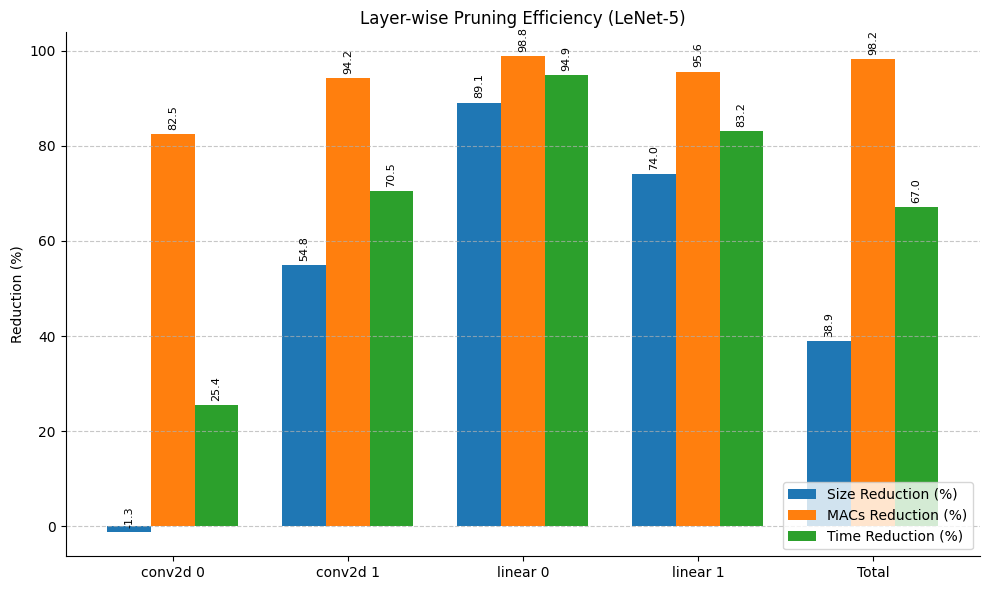

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your table
layers = ['conv2d 0', 'conv2d 1', 'linear 0', 'linear 1', 'Total']
red_size = [-1.3, 54.84, 89.07, 74.00, 38.90]
red_macs = [82.53, 94.17, 98.83, 95.59, 98.21]
red_time = [25.42, 70.48, 94.90, 83.15, 67.05]

# Set up the bar chart
x = np.arange(len(layers))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars
rects1 = ax.bar(x - width, red_size, width, label='Size Reduction (%)', color='#1f77b4')
rects2 = ax.bar(x, red_macs, width, label='MACs Reduction (%)', color='#ff7f0e')
rects3 = ax.bar(x + width, red_time, width, label='Time Reduction (%)', color='#2ca02c')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Reduction (%)')
ax.set_title('Layer-wise Pruning Efficiency (LeNet-5)')
ax.set_xticks(x)
ax.set_xticklabels(layers)
ax.legend(loc='lower right') # Move legend to avoid covering data

# Add gridlines for readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Function to add labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, rotation=90)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('lenet_layerwise_pruning.png', dpi=300)
plt.show()

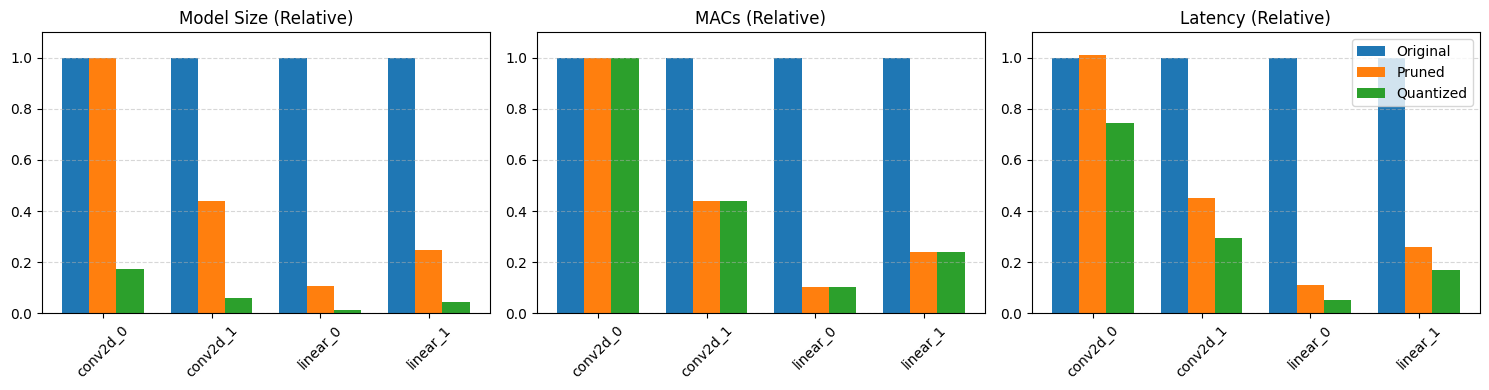

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

layers = ["conv2d_0", "conv2d_1", "linear_0", "linear_1"]

# Normalized values (1 = original)
size_original = np.ones(4)
size_pruned = np.array([1-0, 1-0.562, 1-0.8955, 1-0.7529])
size_quant = np.array([1-0.8253, 1-0.9417, 1-0.9883, 1-0.9559])

mac_original = np.ones(4)
mac_pruned = np.array([1-0, 1-0.5625, 1-0.8958, 1-0.7619])
mac_quant = mac_pruned.copy()  # quant MACs same as pruned in your table

time_original = np.ones(4)
time_pruned = np.array([1+0.013, 1-0.5484, 1-0.8907, 1-0.74])
time_quant = np.array([1-0.2542, 1-0.7048, 1-0.9490, 1-0.8315])

metrics = [
    ("Model Size (Relative)", size_original, size_pruned, size_quant),
    ("MACs (Relative)", mac_original, mac_pruned, mac_quant),
    ("Latency (Relative)", time_original, time_pruned, time_quant),
]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

for ax, (title, orig, pruned, quant) in zip(axes, metrics):
    x = np.arange(len(layers))
    width = 0.25

    ax.bar(x - width, orig, width, label="Original")
    ax.bar(x, pruned, width, label="Pruned")
    ax.bar(x + width, quant, width, label="Quantized")

    ax.set_xticks(x)
    ax.set_xticklabels(layers, rotation=45)
    ax.set_title(title)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

axes[-1].legend(loc="upper right")

plt.tight_layout()
plt.show()


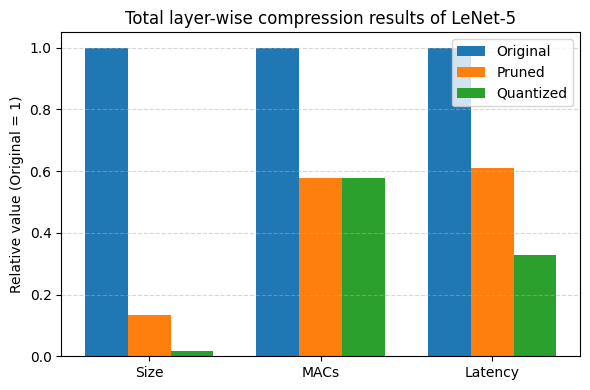

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["Size", "MACs", "Latency"]
original = np.ones(3)
pruned = np.array([0.133, 0.578, 0.610])
quant = np.array([0.018, 0.578, 0.329])

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - width, original, width, label="Original")
ax.bar(x, pruned, width, label="Pruned")
ax.bar(x + width, quant, width, label="Quantized")

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Relative value (Original = 1)")
ax.set_title("Total layer-wise compression results of LeNet-5")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


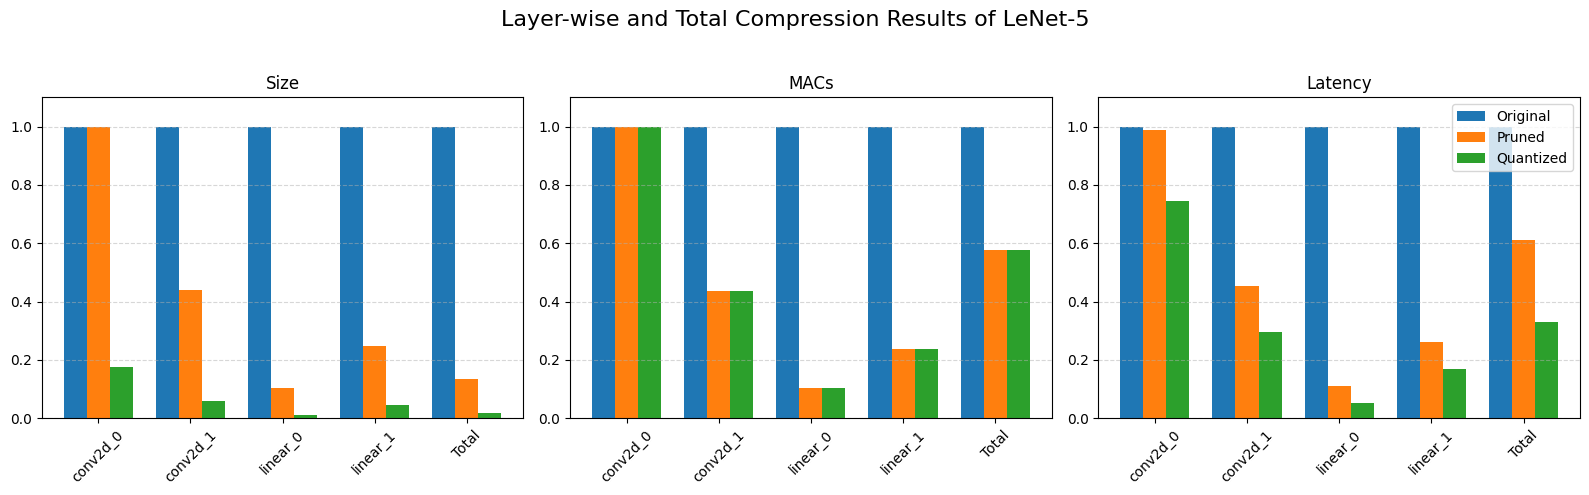

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Layers + total
layers = ["conv2d_0", "conv2d_1", "linear_0", "linear_1", "Total"]

# Normalized Size (Original = 1)
size_original = np.ones(5)  # Original for all layers and total
size_pruned = np.array([1-0, 1-0.562, 1-0.8955, 1-0.7529, 1-0.8668])
size_quant = np.array([1-0.8253, 1-0.9417, 1-0.9883, 1-0.9559, 1-0.9821])

# Normalized MACs
mac_original = np.ones(5)
mac_pruned = np.array([1-0, 1-0.5625, 1-0.8958, 1-0.7619, 1-0.4223])
mac_quant = mac_pruned.copy()  # From table

# Normalized Latency/Time
time_original = np.ones(5)
time_pruned = np.array([1+(-0.013), 1-0.5484, 1-0.8907, 1-0.74, 1-0.389])
time_quant = np.array([1-0.2542, 1-0.7048, 1-0.9490, 1-0.8315, 1-0.6705])

# All metrics in a list for iteration
metrics = [
    ("Size", size_original, size_pruned, size_quant),
    ("MACs", mac_original, mac_pruned, mac_quant),
    ("Latency", time_original, time_pruned, time_quant)
]

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)

width = 0.25
x = np.arange(len(layers))

for ax, (title, orig, pruned, quant) in zip(axes, metrics):
    ax.bar(x - width, orig, width, label="Original")
    ax.bar(x, pruned, width, label="Pruned")
    ax.bar(x + width, quant, width, label="Quantized")
    
    ax.set_xticks(x)
    ax.set_xticklabels(layers, rotation=45)
    ax.set_title(title)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    
axes[-1].legend(loc="upper right")
fig.suptitle("Layer-wise and Total Compression Results of LeNet-5", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


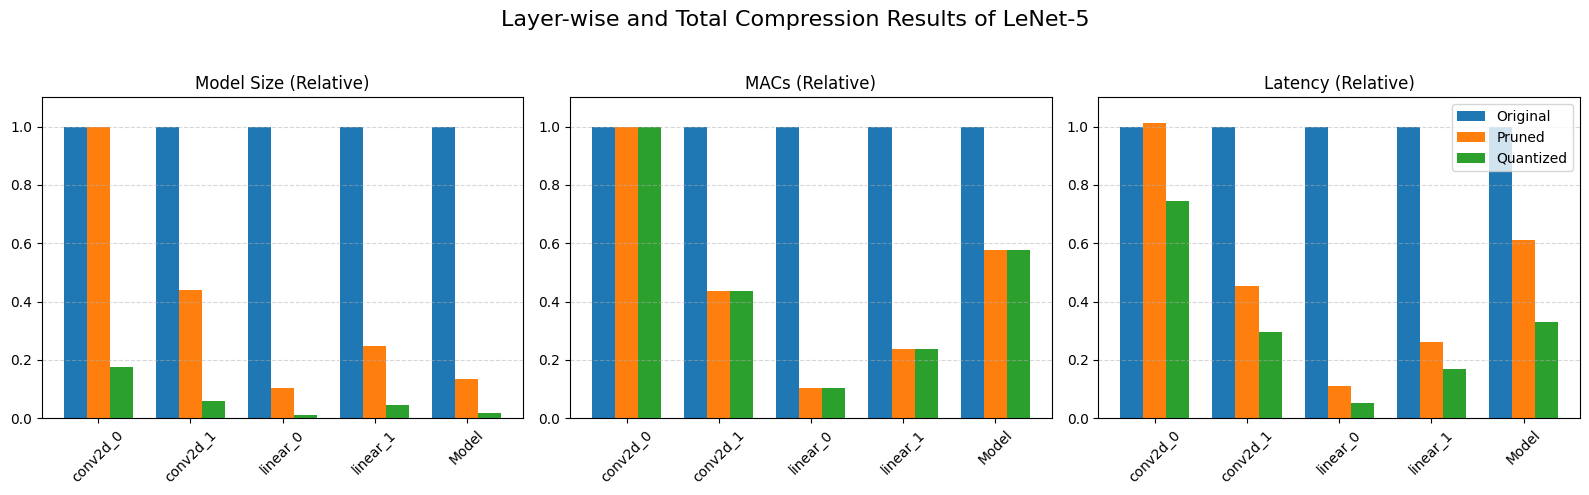

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Layers + total
layers = ["conv2d_0", "conv2d_1", "linear_0", "linear_1", "Model"]

# Normalized values (Original = 1)
size_original = np.ones(5)
size_pruned = np.array([1-0, 1-0.562, 1-0.8955, 1-0.7529, 1-0.8668])
size_quant = np.array([1-0.8253, 1-0.9417, 1-0.9883, 1-0.9559, 1-0.9821])

mac_original = np.ones(5)
mac_pruned = np.array([1-0, 1-0.5625, 1-0.8958, 1-0.7619, 1-0.4223])
mac_quant = mac_pruned.copy()  # quant MACs same as pruned in your table

time_original = np.ones(5)
time_pruned = np.array([1+0.013, 1-0.5484, 1-0.8907, 1-0.74, 1-0.389])
time_quant = np.array([1-0.2542, 1-0.7048, 1-0.9490, 1-0.8315, 1-0.6705])

metrics = [
    ("Model Size (Relative)", size_original, size_pruned, size_quant),
    ("MACs (Relative)", mac_original, mac_pruned, mac_quant),
    ("Latency (Relative)", time_original, time_pruned, time_quant),
]

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)

width = 0.25
x = np.arange(len(layers))

for ax, (title, orig, pruned, quant) in zip(axes, metrics):
    ax.bar(x - width, orig, width, label="Original")
    ax.bar(x, pruned, width, label="Pruned")
    ax.bar(x + width, quant, width, label="Quantized")
    
    ax.set_xticks(x)
    ax.set_xticklabels(layers, rotation=45)
    ax.set_title(title)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

axes[-1].legend(loc="upper right")
fig.suptitle("Layer-wise and Total Compression Results of LeNet-5", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import torch
import os
import sys
from torch.utils.data import DataLoader, TensorDataset

sys.path.append("../../")

# DMC Imports
import development
from development import Sequential
from development import Conv2d, Linear, ReLU, Flatten
from development import QuantizationScheme, QuantizationGranularity

# Defining constants
MODEL_VAR_NAME = "tiny_model"
DEPLOYMENT_BASE_DIR = hp_deployment_base_dir

# 1. Setup Dummy Data (Simulating MNIST)
print("[1] Generating Dummy Data...")
input_shape = (1, 28, 28) # N, C, H, W
X_train = torch.randn(100, 1, 28, 28) # 100 images
y_train = torch.randint(0, 10, (100,))
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=10)

# Calibration data is crucial for Static Quantization to find Min/Max ranges
calibration_data = X_train[0:10] 

# 2. Define the Architecture
# Using DMC layers (Conv2d, Linear) instead of torch.nn
print("[2] Defining Model...")
model = Sequential(
    # Input: 1 channel, Output: 4 filters, 3x3 kernel
    Conv2d(1, 4, kernel_size=3, pad=(1, 1, 1, 1)), 
    ReLU(),
    Flatten(),
    Linear(4 * 28 * 28, 10) 
)
model_size = model.get_size_in_bytes()

# 3. Define Compression Configuration
# We apply Structured Pruning (Stage 1) and 4-bit Static Quantization (Stage 2)
config = {
    "prune_channel": {
        "sparsity": 0.5,  # Remove 50% of filters/neurons
        "metric": "l2"    # Rank importance by L2 norm
    },
    "quantize": {
        "scheme": QuantizationScheme.STATIC, # Pre-compute scales for integer-only inference
        "bitwidth": 4,                       # Aggressive 4-bit compression
        "granularity": QuantizationGranularity.PER_TENSOR
    }
}

# 4. Initialize Compression Pipeline
# This sets up the pruning masks and quantization observers
print("[3] Initializing Compression Pipeline...")
compressed_model = model.init_compress(
    config, 
    input_shape=input_shape, 
    calibration_data=calibration_data
)
compressed_model_size = compressed_model.get_size_in_bytes()

# 5. Fine-Tune (Retraining)
# Recover accuracy lost due to pruning/quantization noise (QAT)
print("[4] Fine-tuning (Retraining)...")
optimizer = torch.optim.SGD(compressed_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

compressed_model.fit(
    train_dataloader=train_loader,
    epochs=2, # Short run for example
    criterion_fun=criterion,
    optimizer_fun=optimizer
)

# 6. Export to C (Stage 3)
# Generates the bit-packed C arrays and header files
print("[5] Exporting to C Code...")

src_dir = os.path.join(DEPLOYMENT_BASE_DIR, "src")
include_dir = os.path.join(DEPLOYMENT_BASE_DIR, "include")
os.makedirs(src_dir, exist_ok=True)
os.makedirs(include_dir, exist_ok=True)


test_input = X_train[:1]
compressed_model.convert_to_c(
    input_shape=input_shape,
    var_name=MODEL_VAR_NAME,
    src_dir=src_dir,
    include_dir=include_dir,
    test_input=test_input # Export one image for C++ verification
)

print(f"The expected output for for the test input is {compressed_model.output_quantize.apply(compressed_model(test_input)).tolist()}")
print(f"Model compressed from an initial size of {model_size/1024}KB to {compressed_model_size/1024}KB, a {(1 - (compressed_model_size/model_size))*100:.2f} reduction in size.")
print(f"Success! C files generated in {DEPLOYMENT_BASE_DIR}")

[1] Generating Dummy Data...
[2] Defining Model...
[3] Initializing Compression Pipeline...
[4] Fine-tuning (Retraining)...


DMC Training (Epochs 1-2):   0%|          | 0/2 [00:00<?, ?it/s]

DMC Training (Epochs 1-2):  50%|█████     | 1/2 [00:00<00:00,  8.88it/s]

epoch    0 | train loss 2.3822


DMC Training (Epochs 1-2): 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]


epoch    1 | train loss 2.1749
[5] Exporting to C Code...
The expected output for for the test input is [[-1, -1, -6, -4, 1, -2, -8, -5, -4, -6]]
Model compressed from an initial size of 122.6953125KB to 7.732421875KB, a 93.70 reduction in size.
Success! C files generated in ./HP HP Pavilion Laptop 15-cs3xxx/


# 🧠 Deep MicroCompression (DMC)

> **Bare-Metal Deep Learning Inference for Resource-Constrained Microcontrollers**

**Deep MicroCompression (DMC)** is a hardware-aware compression pipeline designed to bridge the gap between modern neural networks and ultra-low-power microcontrollers (e.g., ATmega328P, Cortex-M4).

Unlike frameworks that rely on heavy runtime interpreters (like TFLite Micro), DMC optimizes the model at the bit-level and generates a **standalone, dependency-free C library** tailored for integer-only execution.

---

## 🚀 Key Features

### 1. Structured Channel Pruning
* **Dependency-Aware:** Automatically handles channel dependency propagation across layers (Conv2d $\to$ BatchNorm $\to$ ReLU).
* **Physical Reduction:** Unlike "mask-only" pruning, DMC physically removes filters and kernels, resulting in a smaller, dense model that requires no sparse matrix libraries.
* **Sensitivity Analysis:** Built-in tools to profile layer sensitivity (L2 norm) for optimal sparsity configuration.

### 2. Quantization
* **Flexible Precision Schemes:** Supports both Dynamic and Static quantization across configurable bitwidths (8-bit, 4-bit, 2-bit).
* **Quantization-Aware Training (QAT):** Simulates quantization noise during training to recover accuracy at low bitwidths (4-bit/2-bit).
* **Pure Integer Inference:** The Static Quantization mode pre-computes scaling factors and zero-points, enabling fully integer-based arithmetic. This eliminates the need for floating-point operations (FLOPs) at runtime, drastically reducing latency on bare-metal MCUs .

### 3. Hardware-Aware Bit-Packing
* **Compression:** Implements a fixed-length bit-packing scheme. Packs multiple weights (e.g., four 2-bit weights) into single bytes (`uint8_t`), maximizing flash storage density.
* **Fast Unpacking:** Uses optimized C macros (`define.h`) with shift/mask operations to decode weights on-the-fly, avoiding complex Huffman decoders.

### 4. Zero-Dependency C Export
* **Portable:** Generates generic C++ code compatible with any compiler (GCC, Clang) and architecture (AVR, RISC-V, ARM).
* **Static Allocation:** Calculates "Ping-Pong" SRAM buffer requirements (`MAX_OUTPUT_EVEN/ODD`) at compile time, eliminating dynamic memory allocation (`malloc`).

---

## 📊 Performance Highlights

| Model | Dataset | Compression Ratio | Accuracy Drop | Deployment Target |
| :--- | :--- | :--- | :--- | :--- |
| **LeNet-5** | MNIST | **55.8x** | < 1.5% | ATmega32 (2KB RAM) |
| **VGG-13** | CIFAR-100 | **~4x** | ~0.3% | Cortex-M4 |

*Comparison vs. TFLite Micro:* DMC achieves a **15% smaller binary footprint** on LeNet-5 by removing interpreter overhead 8].

---

## 🛠️ Project Architecture
```plaintext
.
├── deployment/                # C/C++ Inference Engine
│   ├── core/                  # Core macros and definitions
│   ├── layers/                # Bare-metal C++ layer implementations
│   ├── models/                # Generated C++ model containers
│   └── deep_microcompression.h # Single include entry point
│
├── development/               # Python Training & Compression Pipeline
│   ├── compressors/           # Pruning and Quantization engines
│   ├── layers/                # PyTorch layers augmented with masking/observers
│   ├── models/                # Sequential container & model definitions
│   ├── tools/                 # Utilities (Library generation, NAS Estimators)
│   └── utils.py               # Bit-packing math (Algorithm 1 & 3)
│
└── requirements.txt

## 💻 Usage Guide

### Phase 1: Exploration & Analysis (Optional)
Before compressing, analyze the model to find the optimal sparsity configuration (as seen in Appendix B).

**1. Sensitivity Analysis:**
[cite_start]Generate layer-wise accuracy drops to identify which layers can be pruned aggressively [cite: 203-204].
```python
from development.core.models import Sequential

# ... load pretrained model ...
sensitivity_data = model.get_layers_prune_channel_sensitivity(
    input_shape=(1, 1, 28, 28),
    data_loader=val_loader,
    metrics={"acc": accuracy_fn},
    train=True  # Enable retraining for accurate recovery estimation
)
# sensitivity_data contains the curves shown in Figure 3/4
```

Here is the Markdown code for the **Usage Guide**, **Embedded Integration**, and **Citation** sections.

````markdown
## 💻 Usage Guide

### Phase 1: Exploration & Analysis (Optional)
Before compressing, analyze the model to find the optimal sparsity configuration (as seen in Appendix B).

**1. Sensitivity Analysis:**
Generate layer-wise accuracy drops to identify which layers can be pruned aggressively.
```python
from development.core.models import Sequential

# ... load pretrained model ...
sensitivity_data = model.get_layers_prune_channel_sensitivity(
    input_shape=(1, 1, 28, 28),
    data_loader=val_loader,
    metrics={"acc": accuracy_fn},
    train=True  # Enable retraining for accurate recovery estimation
)
# sensitivity_data contains the curves shown in Figure 3/4
````

**2. Neural Architecture Search (NAS):**
Randomly sample sparsity configurations to find the "Lottery Ticket" configuration.

```python
search_results = model.get_nas_prune_channel(
    input_shape=(1, 1, 28, 28),
    data_loader=val_loader,
    metric_fun=accuracy_fn,
    num_data=100  # Sample 100 random architectures
)
```

-----

### Phase 1: Compression Pipeline

**1. Define & Train Baseline**

```python
from development.core.models import Sequential
from development.core.layers import Conv2d, Linear, ReLU, Flatten

model = Sequential(
    Conv2d(1, 6, kernel_size=5, pad=(2,2,2,2)),
    ReLU(),
    Flatten(),
    Linear(6*28*28, 10)
)
model.fit(train_loader, epochs=10, ...)
```

**2. Configure Pipeline (Pruning + Quantization)**
Apply the settings derived from your analysis.

```python
from development.core.utils import QuantizationScheme

config = {
    # Stage 1: Structured Pruning
    "prune_channel": {
        "sparsity": {
            "conv2d_0": 0.0,  # Keep sensitive input layers dense
            "conv2d_1": 0.5,  # Prune 50%
            "linear_0": 0.8   # Prune 80% of dense layer
        },
        "metric": "l2"
    },
    # Stage 2: Static Quantization
    "quantize": {
        "scheme": QuantizationScheme.STATIC,
        "bitwidth": 4,         # 4-bit Weights
        "granularity": "PER_TENSOR"
    }
}

# Transform model to Compressed State
# calibration_data is MANDATORY for Static Quantization to determine min/max ranges
compressed_model = model.init_compress(
    config, 
    input_shape=(1, 1, 28, 28), 
    calibration_data=train_sample+data
)
```

**3. Retrain (Fine-Tuning / QAT)**
Recover accuracy lost due to pruning and quantization noise.

```python
# The model is now in "Fake Quantization" mode with Masks active
compressed_model.fit(train_loader, epochs=5, ...)
```

**4. Export to C (Stage 3)**
Generate the dependency-free C library.

```python
# Generates: lenet5.h, lenet5_def.cpp, lenet5_params.cpp
compressed_model.convert_to_c(
    input_shape=(1, 1, 28, 28),
    var_name="lenet5",
    src_dir="./deployment_src",
    include_dir="./deployment_include"
)
```

-----

### Phase 3: Embedded Integration

**1. Generate the Runtime Engine**
Run the utility script to copy the core C++ files to your project.

```bash
python generate_library_tree.py /path/to/my/mcu/project/lib
```

**2. Include & Compile**
Add the generated files to your firmware project (PlatformIO, Keil, CMake).

```c
#include "deep_microcompression.h"
#include "lenet5.h" // Your generated model header

void main() {
    // 1. Prepare Input Data (Quantized to int8 if needed)
    int8_t input_buffer[784] = { ... };

    // 2. Run Inference
    // DMC automatically manages the Ping-Pong SRAM workspace
    lenet5.forward(input_buffer);

    // 3. Access Prediction
    // Result is in the output buffer of the last layer
    int8_t* logits = layers[LAYERS_LEN-1]->output;
    
    // ... post-processing (argmax) ...
}
```

-----

## 📑 Citation

If you use Deep MicroCompression in your research, please refer to the project repository or the associated paper:

```bibtex
@article{dmc2024,
  title={Deep Microcompression: Structured Pruning and Bit-packed Quantization for Microcontrollers},
  author={Surname, Name and Surname, Name},
  journal={IEEE/ACM Proceedings},
  year={2024}
}
```

-----

**License:** MIT
**Authors:** [Your Name/Org]

```
```